In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (precision_recall_curve,PrecisionRecallDisplay)
from sklearn.metrics import precision_score,recall_score
from sklearn import metrics 
import seaborn as sns
import os 
import matplotlib.patches as mpatches
from nlcd_user import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib.colors import ListedColormap
color_algo={'SVR':(0.8941176470588235, 0.10196078431372557, 0.10980392156862737),'ANN':(0.21568627450980393, 0.4941176470588236, 0.7215686274509804),'CIT':(0.3019607843137256, 0.6862745098039216, 0.29019607843137263),'KRR':(0.5960784313725492, 0.3058823529411765, 0.6392156862745098)}

In [2]:
# new function 
def calculate_precision_recall(causal,ind,causal_id=None,indep_id=None):
    #print("using new function, python inbuilt")
    precision=[]
    recall=[]
    presultscausal=pd.read_csv(causal)
    if causal_id:
        presultscausal=presultscausal.iloc[causal_id,]
    presultscausal=presultscausal.iloc[:,:-2]
    presultscausal.insert(0,column='GroundTruth',value=[1]*len(presultscausal))
    presultsind=pd.read_csv(ind)
    if indep_id:
        presultsind=presultsind.iloc[indep_id,]
    presultsind=presultsind.iloc[:,:-2]
    presultsind.insert(0,column='GroundTruth',value=[0]*len(presultsind))
    pMix=pd.concat([presultscausal,presultsind],ignore_index=True)
    if 'p_cit' in pMix.columns:
        pMix.rename(columns={'p_cit':'p_final'}, inplace=True)
    gt=pMix['GroundTruth']
    pred=pMix['p_final']
    mask = ~np.isnan(pred)
    gt=gt[mask]
    pred=pred[mask]
    pred=1-pred  # taking 1 minus , because in our case lesser the p-value, the better. but in the curve function higher the better
    #the function returns decreasing recall values so find the first precision and extend it 
    precision,recall,thresholds=precision_recall_curve(gt,pred,pos_label=1)
    precision[-1]=precision[-2]
    return precision,recall

        

In [3]:
def read_data(data):

    #read the input file 
    fo=open(data, "r")
    L=[]
    A=[]
    B=[]
# the simulated data is generated with a seed at the start of the file
# so we skip it, but not for the yeast data 
# if yeast is present then dont read the seed line
    if(data.find('yeast')==-1 and data.find('human')==-1): #if yeast is not present
        line=fo.readline() # read the line, the control will start from the next line 

    while(1):
    # the first line of the trio is the parameter configuration, skip it 
        line=fo.readline()
    # read the genotype information 
        line=fo.readline()
        if line== "" :
            break
        l = [j for j in line.split()]
        L.append(np.array([int(i) for i in l]))
        line=fo.readline()
        a = [j for j in line.split()]
        A.append(np.array([float(i) for i in a]))
        line=fo.readline()
        b = [j for j in line.split()]
        B.append(np.array([float(i) for i in b]))
#combine all the samples into a list 
    dataset = [i for i in zip(L,A,B)]
    fo.close()
    return dataset

In [4]:
# new function for average precision score
def calculate_avgprecision(causal,ind,causal_id=None,indep_id=None):
    presultscausal=pd.read_csv(causal)
    if causal_id:
        presultscausal=presultscausal.iloc[causal_id,]
    presultscausal=presultscausal.iloc[:,:-2]
    presultscausal.insert(0,column='GroundTruth',value=[1]*len(presultscausal))
    presultsind=pd.read_csv(ind)
    if indep_id:
        presultsind=presultsind.iloc[indep_id,]
    presultsind=presultsind.iloc[:,:-2]
    presultsind.insert(0,column='GroundTruth',value=[0]*len(presultsind))
    pMix=pd.concat([presultscausal,presultsind],ignore_index=True)
    if 'p_cit' in pMix.columns:
        pMix.rename(columns={'p_cit':'p_final'}, inplace=True)
    gt=pMix['GroundTruth']
    pred=pMix['p_final']
    mask = ~np.isnan(pred)
    gt=gt[mask]
    pred=pred[mask]
    pred=1-pred  # taking 1 minus , because in our case lesser the p-value, the better. but in the curve function higher the better
    #the function returns decreasing recall values so find the first precision and extend it 
    return average_precision_score(gt,pred,pos_label=1)


        

In [5]:
def make_table(causal,ind,causal_id=None,indep_id=None,newfunc=True):
    precision=[]
    recall=[]
    TN=[]
    FN=[]
    FP=[]
    TP=[]
    presultscausal=pd.read_csv(causal)
    if causal_id:
        presultscausal=presultscausal.iloc[causal_id,]
    presultscausal=presultscausal.iloc[:,:-2]
    presultscausal.insert(0,column='GroundTruth',value=[1]*len(presultscausal))
    presultsind=pd.read_csv(ind)
    if indep_id:
        presultsind=presultsind.iloc[indep_id,]
    presultsind=presultsind.iloc[:,:-2]
    presultsind.insert(0,column='GroundTruth',value=[0]*len(presultsind))
    pMix=pd.concat([presultscausal,presultsind],ignore_index=True)
    if 'p_cit' in pMix.columns:
        pMix.rename(columns={'p_cit':'p_final'}, inplace=True)
    if newfunc==True:
        print("using new function")
        gt=pMix['GroundTruth']
        pred=pMix['p_final']
        mask = ~np.isnan(pred)
        gt=gt[mask]
        pred=pred[mask]
        pred=1-pred  # taking 1 minus , because in our case lesser the p-value, the better. but in the curve function higher the better
        #the function returns decreasing recall values so find the first precision and extend it 
        precision,recall,thresholds=precision_recall_curve(gt,pred,pos_label=1)
        #remove the last value from precision and recall 
        precision.resize(precision.size-1)
        recall.resize(recall.size-1)
        table=pd.DataFrame(np.column_stack([1-thresholds,precision,recall]),columns=['p_cutoffs','precision','recall'])
        table=table.sort_values(['p_cutoffs'])
    else:
        print("Using old function")
        # removing NaN values, CIT might throw up some NaN values 
        uniq_val=np.unique(pMix['p_final'])
        uniq_val = uniq_val[~np.isnan(uniq_val)]
        for j in range(0,len(uniq_val)):
            i=uniq_val[j]
            #if j==0:  ## extrapolate to the left side 
            #    pMix['results']=pMix.apply (lambda row: 1 if row['p_final'] <=i   else 0, axis=1)
            #    precision.append(precision_score(pMix['GroundTruth'],pMix['results']))
            #    recall.append(0)
            pMix['results']=pMix.apply (lambda row: 1 if row['p_final'] <=i   else 0, axis=1)
            confusion_matrix = metrics.confusion_matrix(pMix['GroundTruth'], pMix['results']) 
            TN.append(confusion_matrix[0][0])
            FN.append(confusion_matrix[1][0])
            FP.append(confusion_matrix[0][1])
            TP.append(confusion_matrix[1][1])
            precision.append(precision_score(pMix['GroundTruth'],pMix['results']))
            recall.append(recall_score(pMix['GroundTruth'],pMix['results']))

        table=pd.DataFrame(np.column_stack([uniq_val,TP,FP,TN,FN,precision,recall]),columns=['p cutoffs','TP','FP','TN','FN','precision','recall'])

            
    return table

In [6]:
def make_ranking_table(causal,ind):
    presultscausal=pd.read_csv(causal)
    if 'p_cit' in presultscausal.columns:
        presultscausal.rename(columns={'p_cit':'p_final'}, inplace=True)
    presultscausal.insert(0,column='GroundTruth',value=['causal']*len(presultscausal))
    presultsind=pd.read_csv(ind)
    if 'p_cit' in presultsind.columns:
        presultsind.rename(columns={'p_cit':'p_final'}, inplace=True)
    presultsind.insert(0,column='GroundTruth',value=['independent']*len(presultsind))
    presultscausal=presultscausal[['p_final','GroundTruth']]
    presultsind=presultsind[['p_final','GroundTruth']]
    finaltable=presultscausal.append(presultsind)
    finaltable.sort_values(['p_final'],inplace=True)
    
    return finaltable
    

In [7]:
def fig2_a():
    ####### figure 2 overlap depiction ############

    dflinear=read_data("./data/Linear500.txt") # going to read the data with the 52nd index 
    dfsine=read_data("./data/Sine500.txt") # going to read the data with the 54th index
    dfsaw=read_data("./data/Saw500.txt") # going to read the data with the 54th index 
    norows = 3
    nocols = 1

    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharey=True, figsize=(4, 10))
    #fig.suptitle('Example plots for different datatypes')

    curr_ax = ax[0]
    plot_index = 0
    curr_ax.scatter(dflinear[52][1], dflinear[52][2], c=dflinear[52][0], cmap='viridis', alpha=0.6)
    curr_ax.axvspan(xmin=0.3, xmax=2, alpha=0.3, color='gray')  # Add shaded area
    curr_ax.set_xlabel('A')
    curr_ax.set_ylabel('B')
    curr_ax.set_title('Linear')
    # Create custom legend handles with correct colors
    unique_labels = set(dfsaw[54][0])
    num_labels = len(unique_labels)
    colors = plt.cm.get_cmap('viridis', num_labels)(range(num_labels))
    cmap = ListedColormap(colors)
    legend_handles = [mpatches.Patch(color=color, label=f'L={label}') for color, label in zip(colors, unique_labels)]

    # Create legend handles and labels for the shaded area
    shade_handle = mpatches.Patch(facecolor='gray', edgecolor='black', alpha=0.3, label='Shaded Area')

    # Combine legend handles and labels
    handles = legend_handles + [shade_handle]
    labels = ['L=0', 'L=1', 'Overlap']

    # Add the combined legend to the subplot
    curr_ax.legend(handles, labels, loc='lower right')

    curr_ax = ax[1]
    plot_index += 1
    curr_ax.scatter(dfsine[54][1], dfsine[54][2], c=dfsine[54][0], cmap='viridis', alpha=0.6)
    curr_ax.axvspan(xmin=0, xmax=2, alpha=0.3, color='gray')  # Add shaded area
    curr_ax.set_xlabel('A')
    curr_ax.set_ylabel('B')
    curr_ax.set_title('Sine')

    curr_ax = ax[2]
    plot_index += 1
    curr_ax.scatter(dfsaw[54][1], dfsaw[54][2], c=dfsaw[54][0], cmap='viridis', alpha=0.6)
    curr_ax.axvspan(xmin=0.3, xmax=2, alpha=0.3, color='gray')  # Add shaded area
    curr_ax.set_xlabel('A')
    curr_ax.set_ylabel('B')
    curr_ax.set_title('Saw')



    plt.tight_layout()
    plt.savefig("./results/journal/plots/fig2_example.png", bbox_inches='tight', dpi=1200)
    plt.savefig('./results/journal/plots/fig2_example.svg', bbox_inches='tight', format='svg', dpi=1200)

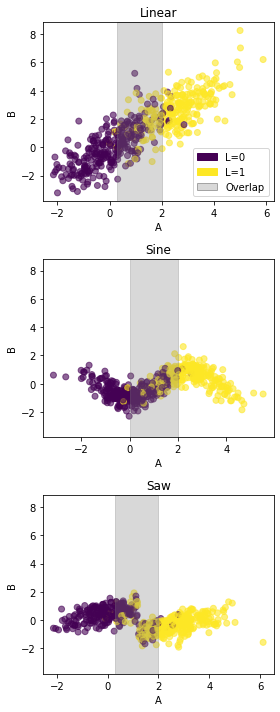

In [8]:
fig2_a()

In [9]:
def fig2_suppl_a():
    ### Figure 2 supplementary ################
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=3
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Precision-Recall Curve plots for 100 permutations ")
    #fig.text(0.5, 1, 'Precision-Recall Curve plots', ha='center')
    #fig.text(0.22, 1, 'Linear', ha='center')
    #fig.text(0.52, 1, 'Sine', ha='center')
    #fig.text(0.85, 1, 'Saw', ha='center')
    #fig.text(0,0.20, 'Sample size 1000', va='center', rotation='vertical')
    #fig.text(0,0.50, 'Sample size 500', va='center', rotation='vertical')
    #fig.text(0,0.79, 'Sample size 300', va='center', rotation='vertical')

    plot_index = 0

    for i in ['300', '500', '1000'] :
        for j in ['Linear', 'Sine', 'Saw']:
            for k in [ '100']: # put 100 permutations in supplementary 
                precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")

                curr_ax = ax[plot_index // nocols, plot_index % nocols]
                
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_algo['CIT'])
                #curr_ax.plot(recall_nlmr_ANN,precision_nlmr_ANN,color=color_algo['ANN'])
                #curr_ax.plot(recall_nlmr_SVR,precision_nlmr_SVR,color=color_algo['SVR'])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_SVR, recall=recall_nlmr_SVR)
                disp.plot(ax=curr_ax, color=color_algo['SVR'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_ANN, recall=recall_nlmr_ANN)
                disp.plot(ax=curr_ax, color=color_algo['ANN'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                if(plot_index // nocols == 0 and plot_index % nocols == 0):
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Sine')
                elif(plot_index // nocols == 0 and plot_index % nocols == 2):
                    curr_ax.set_title('Sawtooth')   
                if(plot_index % nocols == 0 and plot_index//norows==0):
                    curr_ax.set_ylabel('Sample size =300 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==1):
                    curr_ax.set_ylabel('Sample size =500 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==2):
                    curr_ax.set_ylabel('Sample size =1000 \n Precision')
                if(plot_index //nocols == (norows-1)):
                    curr_ax.set_xlabel('Recall')
                if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
                    xindex=norows-1
                    yindex=0
                    handles = [ax[xindex, yindex].lines[3],ax[xindex,yindex].lines[0], ax[xindex, yindex].lines[1],ax[xindex, yindex].lines[2]]
                    labels = ['NLCD (KRR)','NLCD (SVR)', 'NLCD (ANN)',  'CIT (baseline)']
                    curr_ax.legend(handles,labels,loc="lower left")
            

                plot_index += 1

    fig.tight_layout()
    plt.savefig("./results/journal/plots/fig_2_suppl_a.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig_2_suppl_a.svg', bbox_inches='tight',format='svg', dpi=1200)


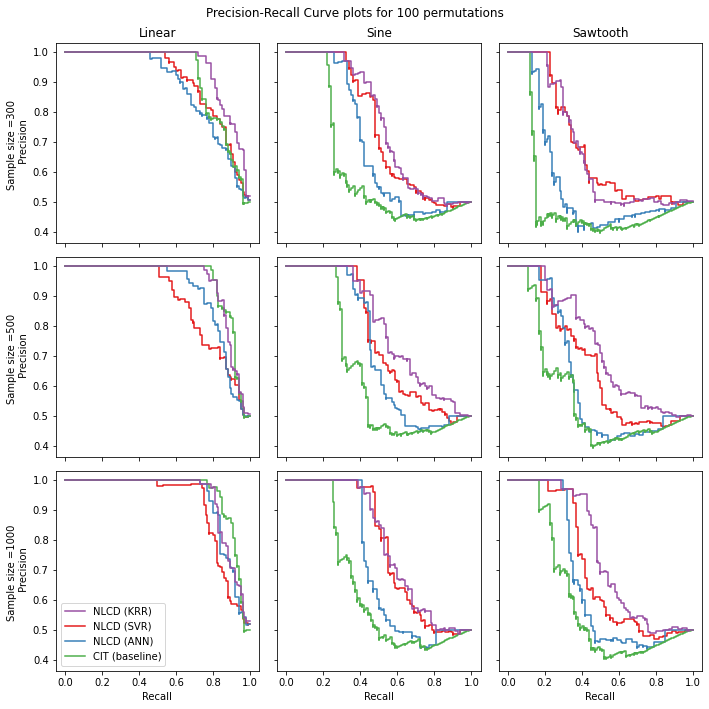

In [14]:
fig2_suppl_a()

In [7]:
def fig2_suppl_b():
    #### Figure 2 supplementary b ###########
    nlcd_dir='./results/journal/2way/'
    norows = 2
    nocols = 2
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(8, 7))
    fig.suptitle("Hex plot of p-values from A->B vs B->A p for NLCD(KRR) 100 permutations ")
    plot_index = 0

    for j in ['Linear', 'Sine', 'Saw', 'Indp']:
        dfcausal = pd.read_csv(nlcd_dir + j + 'KRR500s100perm.csv')
        dfrev = pd.read_csv(nlcd_dir + j + 'KRR500s100perm_rev.csv')
        curr_ax = ax[plot_index // nocols, plot_index % nocols]
        hb = curr_ax.hexbin(dfcausal['p_final'], dfrev['p_final'], gridsize=5, mincnt=1, cmap='Blues',vmin=0,vmax=30)
        
        if(plot_index == 0 or plot_index == 2):
            curr_ax.set_ylabel('B->A')
        else:
            curr_ax.set_ylabel('')
        curr_ax.set_xlabel('A->B ')
        
        if(j == 'Linear'):
            curr_ax.set_title('Linear')
        elif(j == 'Sine'):
            curr_ax.set_title('Sine')
        elif(j == 'Saw'):
            curr_ax.set_title('Sawtooth')
        elif(j == 'Indp'):
            curr_ax.set_title('Independent')
        
        plot_index += 1

    cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])  # Adjust the position and size of the colorbar as needed
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.set_label('Counts')


    #plt.savefig("./results/journal/plots/fig_2_suppl_b.png", bbox_inches='tight', dpi=1200)
    #plt.savefig('./results/journal/plots/fig_2_suppl_b.svg', bbox_inches='tight', format='svg', dpi=1200)

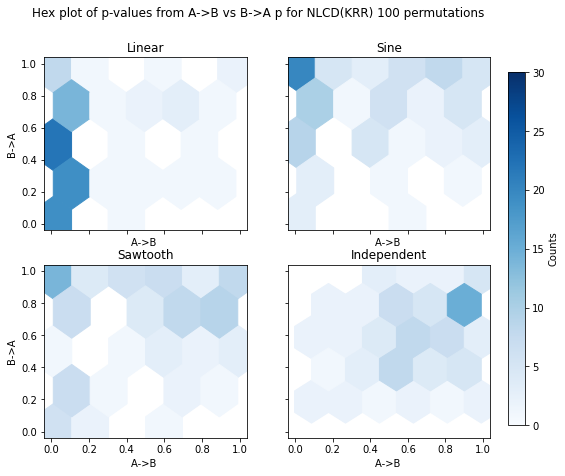

In [11]:
fig2_suppl_b()

In [12]:
def fig2_b():
    ### Figure 2 ################
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=3
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Precision-Recall Curve plots for 500 permutations ")
    plot_index = 0

    for i in ['300', '500', '1000'] :
        for j in ['Linear', 'Sine', 'Saw']:
            for k in [ '500']: # put 100 permutations in supplementary 
                precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")

                curr_ax = ax[plot_index // nocols, plot_index % nocols]
        
                disp = PrecisionRecallDisplay(precision=precision_nlmr_SVR, recall=recall_nlmr_SVR)
                disp.plot(ax=curr_ax, color=color_algo['SVR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_nlmr_ANN, recall=recall_nlmr_ANN)
                disp.plot(ax=curr_ax, color=color_algo['ANN'])
               
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index // nocols == 0 and plot_index % nocols == 0):        
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Sine')
                elif(plot_index // nocols == 0 and plot_index % nocols == 2):
                    curr_ax.set_title('Sawtooth')   
                if(plot_index % nocols == 0 and plot_index//norows==0):
                    curr_ax.set_ylabel('Sample size =300 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==1):
                    curr_ax.set_ylabel('Sample size =500 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==2):
                    curr_ax.set_ylabel('Sample size =1000 \n Precision')
                if(plot_index //nocols == (norows-1)): # if its the last row then add x labels 
                    curr_ax.set_xlabel('Recall')
                if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
                    xindex=norows-1
                    yindex=0
                    handles = [ax[xindex, yindex].lines[2],ax[xindex,yindex].lines[0], ax[xindex, yindex].lines[1],ax[xindex, yindex].lines[3]]
                    labels = ['NLCD (KRR)','NLCD (SVR)', 'NLCD (ANN)',  'CIT (baseline)']
                    curr_ax.legend(handles,labels,loc="lower left")

                
                plot_index += 1

    #plt.tight_layout()
    # Create a common legend
    #handles = [ax[0, 0].lines[0], ax[0, 0].lines[1], ax[0, 0].lines[2], ax[0, 0].lines[3]]
    #labels = ['SVR', 'ANN', 'CIT', 'KRR']
    #fig.legend(handles, labels, loc='lower left')

    fig.tight_layout()
    plt.savefig("./results/journal/plots/fig2.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig2.svg', bbox_inches='tight',format='svg', dpi=1200)


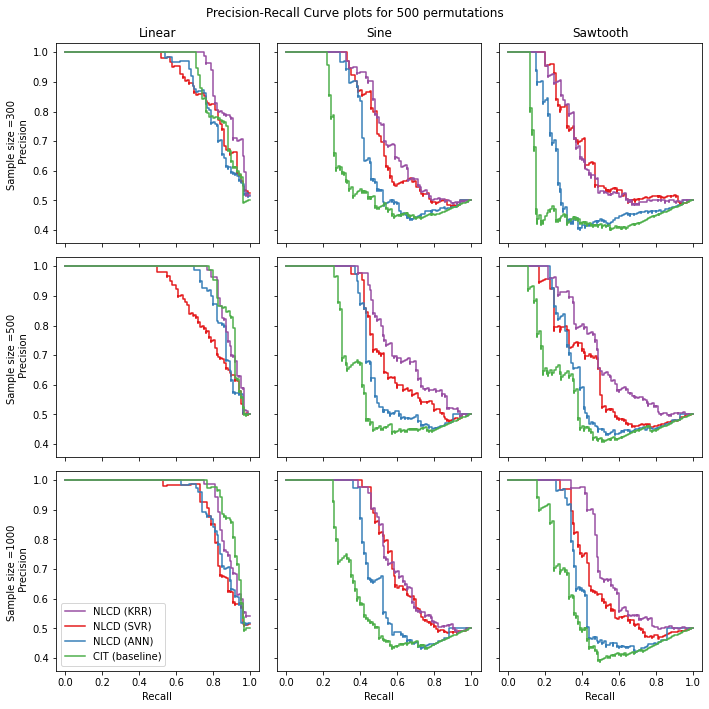

In [13]:
fig2_b()

In [46]:
def fig2_b_mod_main():
    ### Figure 2 ################
    #this is for sample 500
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=3
    nocols=1
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(4,10))
    #fig.suptitle("Precision-Recall Curve plots for 500 permutations ")
    plot_index = 0

    for i in [ '500'] :
        for j in ['Linear', 'Sine', 'Saw']:
            for k in [ '500']: # put 100 permutations in supplementary 
                precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")

                curr_ax = ax[plot_index]
        
                disp = PrecisionRecallDisplay(precision=precision_nlmr_SVR, recall=recall_nlmr_SVR)
                disp.plot(ax=curr_ax, color=color_algo['SVR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_nlmr_ANN, recall=recall_nlmr_ANN)
                disp.plot(ax=curr_ax, color=color_algo['ANN'])
               
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index  == 0 ):        
                    curr_ax.set_title('Linear')
                elif(plot_index == 1 ):
                    curr_ax.set_title('Sine')
                elif(plot_index  == 2 ):
                    curr_ax.set_title('Sawtooth')   
                if(plot_index ==2):
                    #curr_ax.set_ylabel('Sample size =500 \n Precision') 
                    curr_ax.set_xlabel('Recall')
                curr_ax.set_ylabel('Precision') 
                
                if(plot_index==0) :# if the plot is lower left, then add the legend in that plot
                    xindex=norows-1
                    yindex=0
                    handles = [ax[ yindex].lines[2],ax[yindex].lines[0], ax[ yindex].lines[1],ax[yindex].lines[3]]
                    labels = ['NLCD (KRR)','NLCD (SVR)', 'NLCD (ANN)',  'CIT (baseline)']
                    curr_ax.legend(handles,labels,loc="lower left")

                
                plot_index += 1

    #plt.tight_layout()
    # Create a common legend
    #handles = [ax[0, 0].lines[0], ax[0, 0].lines[1], ax[0, 0].lines[2], ax[0, 0].lines[3]]
    #labels = ['SVR', 'ANN', 'CIT', 'KRR']
    #fig.legend(handles, labels, loc='lower left')

    fig.tight_layout()
    plt.savefig("./results/journal/plots/fig2_mod_main.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig2_mod_main.svg', bbox_inches='tight',format='svg', dpi=1200)


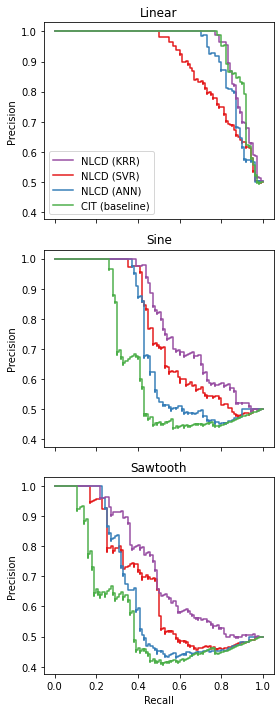

In [47]:

fig2_b_mod_main()

In [88]:
def fig2_b_mod_supp():
    ### Figure 2 ################
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=2
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(7,6.6))
    fig.suptitle("Precision-Recall Curve plots for 500 permutations ")
    plot_index = 0

    for i in ['300', '1000'] :
        for j in ['Linear', 'Sine', 'Saw']:
            for k in [ '500']: # put 100 permutations in supplementary 
                precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")

                curr_ax = ax[plot_index // nocols, plot_index % nocols]
        
                disp = PrecisionRecallDisplay(precision=precision_nlmr_SVR, recall=recall_nlmr_SVR)
                disp.plot(ax=curr_ax, color=color_algo['SVR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_nlmr_ANN, recall=recall_nlmr_ANN)
                disp.plot(ax=curr_ax, color=color_algo['ANN'])
               
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index // nocols == 0 and plot_index % nocols == 0):        
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Sine')
                elif(plot_index // nocols == 0 and plot_index % nocols == 2):
                    curr_ax.set_title('Sawtooth')   
                if(plot_index % nocols == 0 and plot_index//norows==0):
                    curr_ax.set_ylabel('Sample size =300 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==1):
                    curr_ax.set_ylabel('Sample size =1000 \n Precision')
                if(plot_index //nocols == (norows-1)): # if its the last row then add x labels 
                    curr_ax.set_xlabel('Recall')
                if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
                    xindex=norows-1
                    yindex=0
                    handles = [ax[xindex, yindex].lines[2],ax[xindex,yindex].lines[0], ax[xindex, yindex].lines[1],ax[xindex, yindex].lines[3]]
                    labels = ['NLCD (KRR)','NLCD (SVR)', 'NLCD (ANN)',  'CIT (baseline)']
                    curr_ax.legend(handles,labels,loc="lower left")

                
                plot_index += 1

    #plt.tight_layout()
    # Create a common legend
    #handles = [ax[0, 0].lines[0], ax[0, 0].lines[1], ax[0, 0].lines[2], ax[0, 0].lines[3]]
    #labels = ['SVR', 'ANN', 'CIT', 'KRR']
    #fig.legend(handles, labels, loc='lower left')

    fig.tight_layout()
    plt.savefig("./results/journal/plots/fig2_b_mod_supp.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig2_b_mod_supp.svg', bbox_inches='tight',format='svg', dpi=1200)


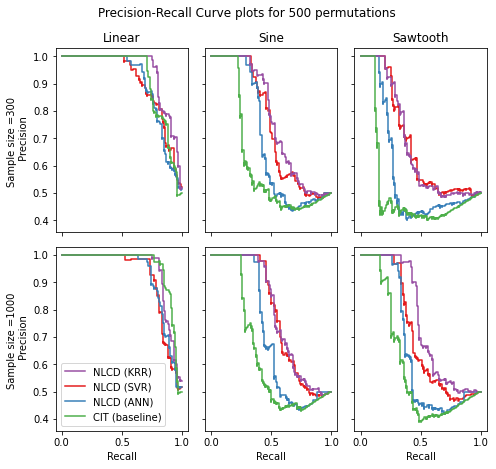

In [89]:
fig2_b_mod_supp()

In [15]:
def fig2_suppl_c():
    ### Figure 2 supplementary c c################
    nlcd_dir="./results/journal/10run/runvariation/nlcd/"
    cit_dir="./results/journal/10run/runvariation/cit/"
    norows=2
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(8,5))
    fig.suptitle("PR curves for 10 runs ")

    plot_index = 0

    for k in [ '100','500']: 
        for j in ['Linear','Sine','Saw']:
            for i in ['1','2','3','4','5','6','7','8','9','10']:
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir+j+"KRR500s" + k +"perm"+i+"run"+".csv", nlcd_dir+"IndpKRR500s" + k + "perm"+i+"run"+".csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir+j+"500cit" + k + "perm"+"run"+i+".csv", cit_dir+"Indp500cit" + k + "perm"+"run"+i+".csv")

                curr_ax = ax[ plot_index//nocols,plot_index % nocols]

                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])  
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
            if(plot_index // nocols == 0 and plot_index % nocols == 0):
                curr_ax.set_title("Linear")
                curr_ax.set_ylabel("Permutations=100 \n Precision ")
            if(plot_index // nocols == 0 and plot_index % nocols == 1):
                curr_ax.set_title("Sine")
            if(plot_index // nocols == 0 and plot_index % nocols == 2):
                curr_ax.set_title("Sawtooth")
            if(plot_index // nocols == 1 ):
                if(plot_index % nocols == 0):
                    curr_ax.set_ylabel("Permutations=500 \n Precision")
                curr_ax.set_xlabel("Recall")
                
            if(plot_index // nocols == 1 and plot_index % nocols == 0) :
                xindex=norows-1
                yindex=0
                handles = [curr_ax.lines[0],curr_ax.lines[1]]
                labels = ['NLCD (KRR)','CIT (baseline)']
                curr_ax.legend(handles,labels,loc="lower left")
            
            plot_index += 1
        


    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig_2_suppl_c.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig_2_suppl_c.svg', bbox_inches='tight',format='svg', dpi=1200)


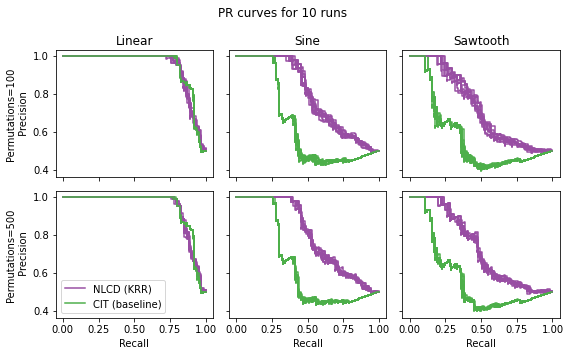

In [16]:
fig2_suppl_c()

In [17]:
def fig2_suppl_d():
    ### Figure 2 supplementary d ################
    nlcd_dir="./results/journal/10run/datavariation/nlcd/"
    cit_dir="./results/journal/10run/datavariation/cit/"
    norows=2
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(8,5))
    fig.suptitle("PR curves for 10 different datasets ")

    plot_index = 0

    for k in [ '100','500']: 
        for j in ['Linear','Sine','Saw']:
            for i in ['1','2','3','4','5','6','7','8','9','10']:
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir+j+"KRR500s" + k +"perm"+i+"run"+".csv", nlcd_dir+"IndpKRR500s" + k + "perm"+i+"run"+".csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir+j+"500cit" + k + "perm"+"run"+i+".csv", cit_dir+"Indp500cit" + k + "perm"+"run"+i+".csv")

                curr_ax = ax[ plot_index//nocols,plot_index % nocols]

                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])#,marker='.') #https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_algo['KRR'])
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_algo['CIT'])    
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
            if(plot_index // nocols == 0 and plot_index % nocols == 0):
                curr_ax.set_title("Linear")
                curr_ax.set_ylabel("Permutations=100 \n Precision")
            if(plot_index // nocols == 0 and plot_index % nocols == 1):
                curr_ax.set_title("Sine")
            if(plot_index // nocols == 0 and plot_index % nocols == 2):
                curr_ax.set_title("Sawtooth")
            if(plot_index // nocols == 1 ):
                if(plot_index % nocols == 0):
                    curr_ax.set_ylabel("Permutations=500 \n Precision")
                curr_ax.set_xlabel("Recall")
                
            if(plot_index // nocols == 1 and plot_index % nocols == 0) :
                xindex=norows-1
                yindex=0
                handles = [curr_ax.lines[0],curr_ax.lines[1]]
                labels = ['NLCD (KRR)','CIT (baseline)']
                curr_ax.legend(handles,labels,loc="lower left")
            
            plot_index += 1
        


    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig_2_suppl_d.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig_2_suppl_d.svg', bbox_inches='tight',format='svg', dpi=1200)


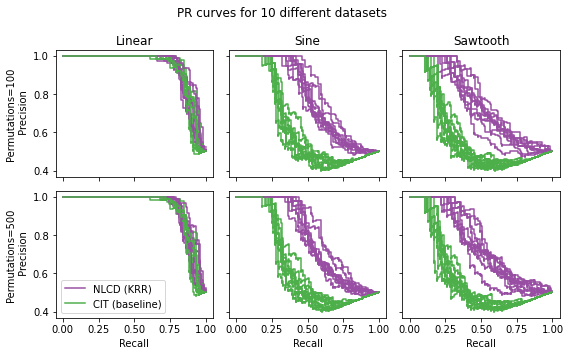

In [18]:
fig2_suppl_d()

In [61]:
def fig4_a():
    ### Figure 3 variance plot #################### 
    #sample size of 500 and 100 permutations
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=1
    nocols=4
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,3))
    #fig.suptitle("Performance when the variance changes for sample size of 500 ")
    #fig.text(0.5, 1, 'Precision-Recall Curve plots', ha='center')
    #fig.text(0.22, 1, 'Linear', ha='center')
    #fig.text(0.52, 1, 'Sine', ha='center')
    #fig.text(0.85, 1, 'Saw', ha='center')
    #fig.text(0,0.20, 'Sample size 1000', va='center', rotation='vertical')
    color_purple  = sns.color_palette("Purples", 3)
    color_green = sns.color_palette("Greens", 3)

    #fig.text(0,0.27, 'Same variance', va='center', rotation='vertical')
    #fig.text(0,0.71, 'Different variance', va='center', rotation='vertical')
    plot_index = 0

    for j in ['Linearvar', 'Paravar','Linear','Para']:
        col_indx=0
        #curr_ax = ax[plot_index // nocols, plot_index % nocols]
        curr_ax=ax[plot_index]
        #for i in ['300', '500', '1000'] :
        for i in ['500']:
            for k in [ '100']: 
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                print("Datatype",j,"Sample",i,"Permutations",k)
                print("AUC CIT",auc(recall_CIT, precision_CIT))
                print("AUC NLMR",auc(recall_nlmr_KRR, precision_nlmr_KRR))
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_algo['CIT'])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index ==0 or plot_index==2):        
                    curr_ax.set_title('Linear')
                elif(plot_index==1 or plot_index==3):
                    curr_ax.set_title('Parabola')
                if(plot_index == 0):   # if its the second row then add the y labels 
                    curr_ax.set_ylabel('Different variance \n Precision')
                if(plot_index == 2):
                    curr_ax.set_ylabel("Same variance \n Precision")
                #if(plot_index //nocols == (norows-1)): # if its the last row then add x labels 
                curr_ax.set_xlabel('Recall')
                #col_indx += 1
        #if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
        if(plot_index==0) :
            xindex=norows-1
            yindex=0
            handles = [ax[ yindex].lines[0], ax[yindex].lines[1]]
            labels = ['CIT','NLCD (KRR)']
            curr_ax.legend(handles,labels,loc="lower left")
            
                
        
        plot_index+=1

    fig.tight_layout()
    plt.savefig("./results/journal/plots/fig4_var.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig4_var.svg', bbox_inches='tight',format='svg', dpi=1200)


Datatype Linearvar Sample 500 Permutations 100
AUC CIT 0.9286210921343341
AUC NLMR 0.9876557017074585
Datatype Paravar Sample 500 Permutations 100
AUC CIT 0.8050386721635641
AUC NLMR 0.9771324719067886
Datatype Linear Sample 500 Permutations 100
AUC CIT 0.9475736626473172
AUC NLMR 0.9430287238370443
Datatype Para Sample 500 Permutations 100
AUC CIT 0.9629754325876296
AUC NLMR 0.9584140502594791


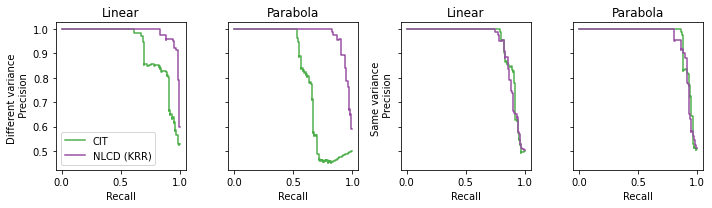

In [62]:
fig4_a()

In [21]:
def fig4_suppl():
    #### Figure 3 supplementary ######
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=2
    nocols=2
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Performance when the variance changes for sample sizes of 300 and 1000 ")
    color_purple  = sns.color_palette("Purples", 2)
    color_green = sns.color_palette("Greens", 2)
    plot_index = 0

    for j in ['Linearvar', 'Paravar','Linear','Para']:
        col_indx=0
        curr_ax = ax[plot_index // nocols, plot_index % nocols]
        for i in ['300', '1000'] :
        #for i in ['500']:
            for k in [ '100']: 
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_green[col_indx])

                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_green[col_indx])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_purple[col_indx])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_purple[col_indx])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index // nocols == 0 and plot_index % nocols == 0):        
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Parabola')
                if(plot_index % nocols == 0):   # if its the second row then add the y labels 
                    curr_ax.set_ylabel('Precision')
                if(plot_index % nocols == 0 and plot_index // norows  == 0):  
                    curr_ax.set_ylabel('Different Variance \n Precision')
                if(plot_index % nocols == 0 and plot_index // norows  == 1):  
                    curr_ax.set_ylabel('Same Variance \n Precision')
                if(plot_index //nocols == (norows-1)): # if its the last row then add x labels 
                    curr_ax.set_xlabel('Recall')
                col_indx += 1
        if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
            xindex=norows-1
            yindex=0
            handles = [ax[xindex, yindex].lines[1], ax[xindex, yindex].lines[3],ax[xindex, yindex].lines[0], ax[xindex, yindex].lines[2]]
            labels = ['NLCD (300)','NLCD (1000)','CIT (300)','CIT (1000)']
            curr_ax.legend(handles,labels,loc="lower left")
            
                
        
        plot_index+=1

    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig4_var_suppl.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig4_var_suppl.svg', bbox_inches='tight',format='svg', dpi=1200)


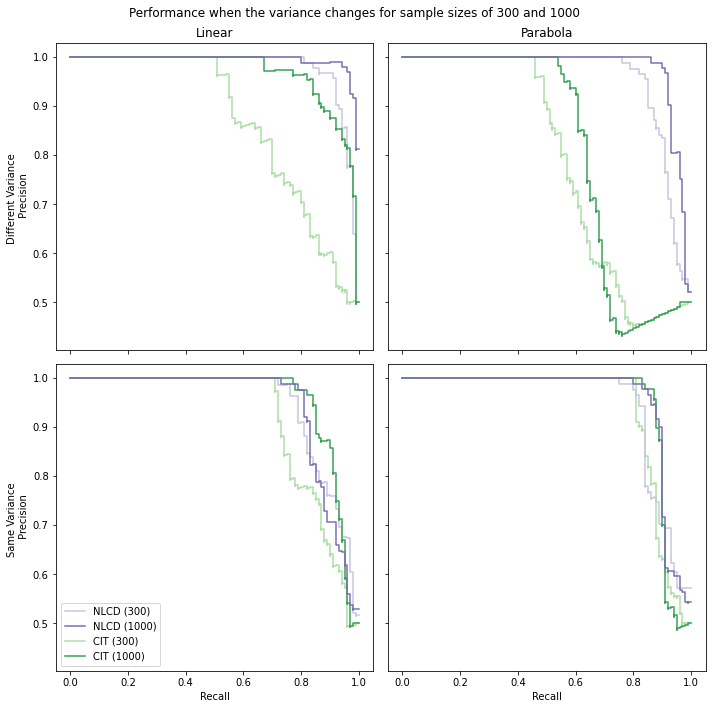

In [22]:
fig4_suppl()

In [23]:
def fig4_a_norm():
    ### Figure 3 variance plot #################### 
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=2
    nocols=2
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Performance when the variance changes for sample size of 300 after normalizing only A")
    #fig.text(0.5, 1, 'Precision-Recall Curve plots', ha='center')
    #fig.text(0.22, 1, 'Linear', ha='center')
    #fig.text(0.52, 1, 'Sine', ha='center')
    #fig.text(0.85, 1, 'Saw', ha='center')
    #fig.text(0,0.20, 'Sample size 1000', va='center', rotation='vertical')
    color_purple  = sns.color_palette("Purples", 3)
    color_green = sns.color_palette("Greens", 3)

    #fig.text(0,0.27, 'Same variance', va='center', rotation='vertical')
    #fig.text(0,0.71, 'Different variance', va='center', rotation='vertical')
    plot_index = 0

    for j in ['Linearvar', 'Paravar','Linear','Para']:
        col_indx=0
        curr_ax = ax[plot_index // nocols, plot_index % nocols]
        #for i in ['300', '500', '1000'] :
        for i in ['300']:
            for k in [ '100']: 
                if j=="Linearvar" or j=="Paravar":
                    precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "NORMs" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                    precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j +"norm"+ i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                else:
                    precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                    precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
             
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_algo['CIT'])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index // nocols == 0 and plot_index % nocols == 0):        
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Parabola')
                if(plot_index == 0):   # if its the second row then add the y labels 
                    curr_ax.set_ylabel('Different variance \n Precision')
                if(plot_index == 2):
                    curr_ax.set_ylabel("Same variance \n Precision")
                if(plot_index //nocols == (norows-1)): # if its the last row then add x labels 
                    curr_ax.set_xlabel('Recall')
                col_indx += 1
        if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
            xindex=norows-1
            yindex=0
            handles = [ax[xindex, yindex].lines[0], ax[xindex, yindex].lines[1]]
            labels = ['CIT','NLCD (KRR)']
            curr_ax.legend(handles,labels,loc="lower left")
            
                
        
        plot_index+=1

    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig4_var.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig4_var.svg', bbox_inches='tight',format='svg', dpi=1200)


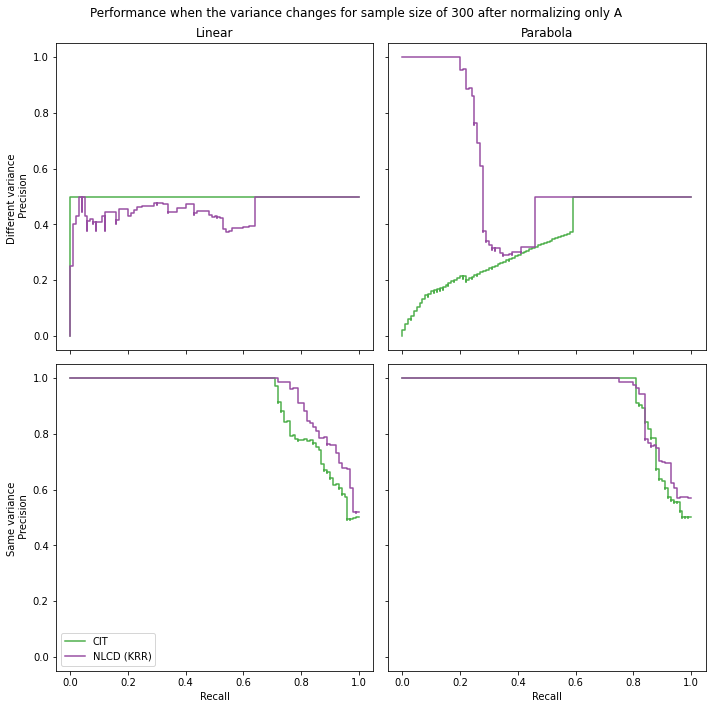

In [24]:
fig4_a_norm()

In [25]:
def fig4_a_normboth():
    ### Figure 3 variance plot #################### 
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=2
    nocols=2
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Performance comparison between normalized vs unnormalized variance for sample size of 500")
    #fig.text(0.5, 1, 'Precision-Recall Curve plots', ha='center')
    #fig.text(0.22, 1, 'Linear', ha='center')
    #fig.text(0.52, 1, 'Sine', ha='center')
    #fig.text(0.85, 1, 'Saw', ha='center')
    #fig.text(0,0.20, 'Sample size 1000', va='center', rotation='vertical')
    color_purple  = sns.color_palette("Purples", 3)
    color_green = sns.color_palette("Greens", 3)

    #fig.text(0,0.27, 'Same variance', va='center', rotation='vertical')
    #fig.text(0,0.71, 'Different variance', va='center', rotation='vertical')
    plot_index = 0

    for j in ['Linearvar', 'Paravar','Linear','Para']:
        col_indx=0
        curr_ax = ax[plot_index // nocols, plot_index % nocols]
        #for i in ['300', '500', '1000'] :
        for i in ['500']:
            for k in [ '100']: 
                if j=="Linearvar" or j=="Paravar":
                    precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "NORMBOTHs" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                    precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j +"normboth"+ i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                else:
                    j=j+'var'
                    precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                    precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
             
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_algo['CIT'])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                # set datatype as titles 
                if(plot_index // nocols == 0 and plot_index % nocols == 0):        
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Parabola')
                if(plot_index == 0):   # if its the second row then add the y labels 
                    curr_ax.set_ylabel('With variance normalization \n Precision')
                if(plot_index == 2):
                    curr_ax.set_ylabel("Without variance normalization \n Precision")
                if(plot_index //nocols == (norows-1)): # if its the last row then add x labels 
                    curr_ax.set_xlabel('Recall')
                col_indx += 1
        if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
            xindex=norows-1
            yindex=0
            handles = [ax[xindex, yindex].lines[0], ax[xindex, yindex].lines[1]]
            labels = ['CIT','NLCD (KRR)']
            curr_ax.legend(handles,labels,loc="lower left")
            
                
        
        plot_index+=1

    fig.tight_layout()
    #plt.savefig("./results/journal/plots/supp_var_norm.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/supp_var_norm.svg', bbox_inches='tight',format='svg', dpi=1200)


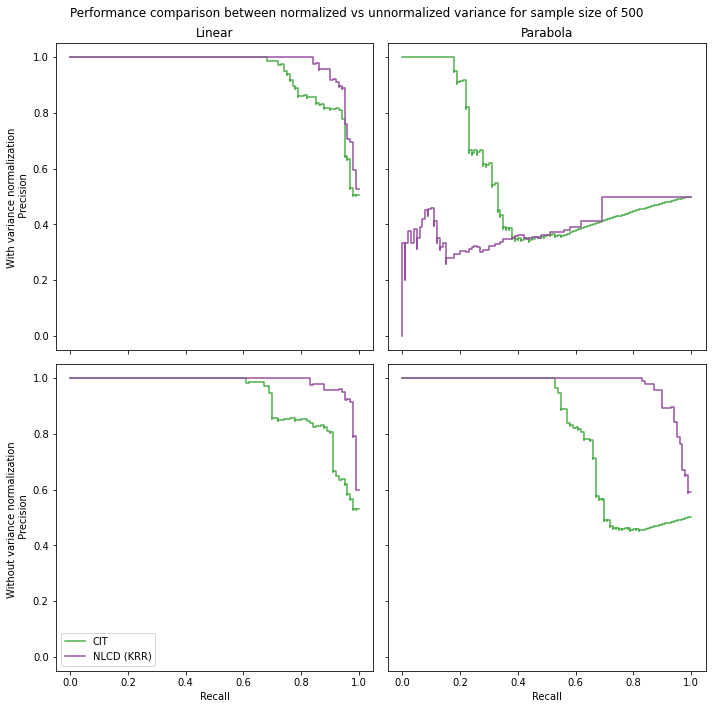

In [26]:
fig4_a_normboth()

In [82]:
def fig3():

    norows=4
    nocols=3
    nlcd_dir='./results/journal/simulation/nlcd/'
    cit_dir='./results/journal/simulation/cit/'
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Tests comparison of NLCD vs CIT p-values : 500 sample size , 500 permutations ")
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    for plot_index in [0,3,6,9]:
        if plot_index==0:
            x = 'p_LassocB'
            y = 'p_TL'
        elif plot_index==3:
            x='p_LassocA|B'
            y='p_GL'
        elif plot_index==6:
            x='p_AassocB|L'
            y='p_TG'
        elif plot_index==9:
            x='p_LindB|A'
            y='p_Lind'
        for j in ['Linear', 'Sine', 'Saw']: 
                    
            
            curr_ax = ax[plot_index // nocols, plot_index % nocols]
            curr_ax.set_ylabel('')
            curr_ax.set_xlabel('')
            dfnlcd=pd.read_csv(nlcd_dir+j+'KRR500s500perm.csv')
            dfcit=pd.read_csv(cit_dir+j+'500cit500perm.csv') 

            #return dfnlcd[x],dfcit[y]
            hb=curr_ax.hexbin(dfnlcd[x], dfcit[y], gridsize=5,mincnt=1, cmap='Blues',vmin=0,vmax=100)
            #if(j=='Sine' and x=='p_AassocB|L'):
            #    cbar = fig.colorbar(hb, cax=cbar_ax)
            if(plot_index//nocols == 0 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel('<----------NLCD L ~ B---------->')
            if(plot_index//nocols == 1 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel('<----------NLCD L ~ A|B-------->')
            if(plot_index//nocols == 2 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel('<----------NLCD A ~ B|L-------->')
            if(plot_index//nocols == 3 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel(r'<----------NLCD L $\bot$ B|A-------->')

            if(plot_index // nocols == 0 and plot_index % nocols == 0):
                curr_ax.set_title('Linear')
            elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                curr_ax.set_title('Sine')
            elif(plot_index // nocols == 0 and plot_index % nocols == 2):
                curr_ax.set_title('Sawtooth')   
            if(plot_index % nocols == 0 and plot_index//nocols == 0):
                curr_ax.set_ylabel(' CIT L ~ B')
            if(plot_index % nocols == 0 and plot_index//nocols == 1 ):
                curr_ax.set_ylabel(' CIT L ~ A|B')
            if(plot_index % nocols == 0 and plot_index // nocols == 2):
                curr_ax.set_ylabel(' CIT A ~ B|L')
            if(plot_index % nocols == 0 and plot_index // nocols == 3):
                curr_ax.set_ylabel(r' CIT L $\bot$ B|A')
            
            

            plot_index += 1

    cbar = fig.colorbar(hb, cax=cbar_ax)
    #cbar = fig.colorbar
    cbar.set_label('Counts')

    #plt.savefig("./results/journal/plots/fig_3.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig_3.svg', bbox_inches='tight',format='svg', dpi=1200)

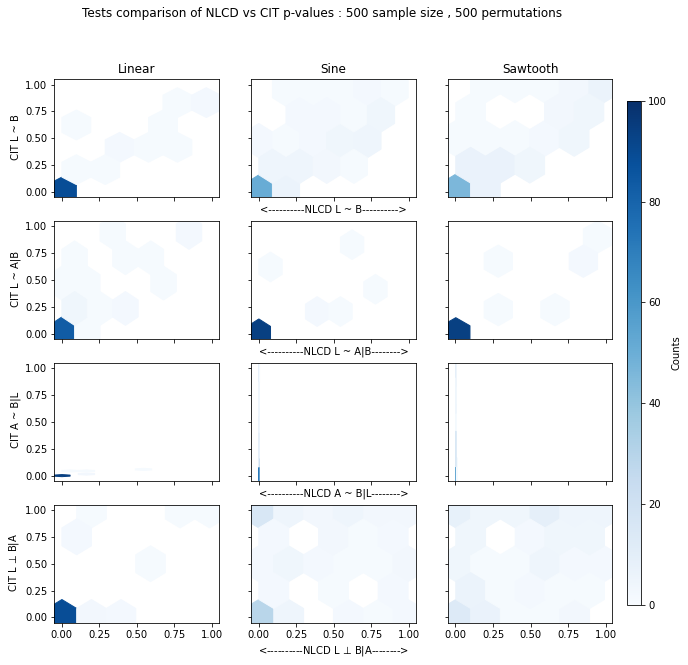

In [83]:
fig3() #not being used in the current paper

In [71]:
def fig3_mod_main():

    norows=1
    nocols=3
    nlcd_dir='./results/journal/simulation/nlcd/'
    cit_dir='./results/journal/simulation/cit/'
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(5,3))
    #fig.suptitle("Test 3 comparison of NLCD vs CIT p-values :\n 500 sample size , 500 permutations ")
    #cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar_ax = fig.add_axes([0.98, 0.15, 0.02, 0.7])
    x='p_AassocB|L'
    y='p_TG'
    count=0
    for j in ['Linear', 'Sine', 'Saw']: 
                    
        curr_ax = ax[count]
        count+=1
        curr_ax.set_ylabel('')
        curr_ax.set_xlabel('')
        dfnlcd=pd.read_csv(nlcd_dir+j+'KRR500s500perm.csv')
        dfcit=pd.read_csv(cit_dir+j+'500cit500perm.csv') 
        hb=curr_ax.hexbin(dfnlcd[x], dfcit[y], gridsize=5,mincnt=1, cmap='plasma',vmin=0,vmax=100)
        if(count==2 ):
            curr_ax.set_xlabel('NLCD A ~ B|L', labelpad=20)

        if(count==1):
            curr_ax.set_title('Linear')
        if(count==2):
            curr_ax.set_title('Sine')
        if(count==3):
            curr_ax.set_title('Sawtooth')   
        if(count==1):
            curr_ax.set_ylabel(' CIT A ~ B|L')
            
            

    cbar = fig.colorbar(hb, cax=cbar_ax)
    #cbar = fig.colorbar
    cbar.set_label('Counts')
    plt.tight_layout()
    plt.savefig("./results/journal/plots/fig_3_mod_main.png",bbox_inches='tight',dpi=1200)
    plt.savefig('./results/journal/plots/fig_3_mod_main.svg', bbox_inches='tight',format='svg', dpi=1200)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


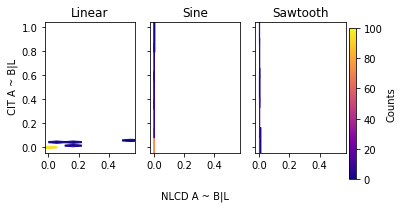

In [72]:
fig3_mod_main()

In [86]:
def fig3_mod_supp():
    norows = 3
    nocols = 3
    nlcd_dir = './results/journal/simulation/nlcd/'
    cit_dir = './results/journal/simulation/cit/'
    
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10, 10))
    #fig.suptitle("Tests comparison of NLCD vs CIT p-values: \n 500 sample size, 500 permutations")
    
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    for row_index in range(norows):

        for col_index, j in enumerate(['Linear', 'Sine', 'Saw']):
            plot_index = row_index * nocols + col_index
            if plot_index == 0:
                x = 'p_LassocB'
                y = 'p_TL'
            elif plot_index == 3:
                x = 'p_LassocA|B'
                y = 'p_GL'
            elif plot_index == 6:
                x = 'p_LindB|A'
                y = 'p_Lind'

            curr_ax = ax[row_index, col_index]
            curr_ax.set_ylabel('')
            curr_ax.set_xlabel('')
            dfnlcd = pd.read_csv(nlcd_dir + j + 'KRR500s500perm.csv')
            dfcit = pd.read_csv(cit_dir + j + '500cit500perm.csv')

            hb = curr_ax.hexbin(dfnlcd[x], dfcit[y], gridsize=5, mincnt=1, cmap='plasma', vmin=0, vmax=100)

            if col_index == 1:
                if row_index == 0:
                    curr_ax.set_xlabel('NLCD L ~ B',labelpad=15)
                elif row_index == 1:
                    curr_ax.set_xlabel('NLCD L ~ A|B',labelpad=15)
                elif row_index == 2:
                    curr_ax.set_xlabel(r'NLCD L $\bot$ B|A',labelpad=15)
            if row_index == 0:
                if col_index == 0:
                    curr_ax.set_title('Linear')
                elif col_index == 1:
                    curr_ax.set_title('Sine')
                elif col_index == 2:
                    curr_ax.set_title('Sawtooth')
            
            if col_index == 0 and row_index == 0:
                curr_ax.set_ylabel('CIT L ~ B')
            elif col_index == 0 and row_index == 1:
                curr_ax.set_ylabel('CIT L ~ A|B')
            elif col_index == 0 and row_index == 2:
                curr_ax.set_ylabel('CIT A ~ B|L')
            elif col_index == 0 and row_index == 3:
                curr_ax.set_ylabel(r'CIT L $\bot$ B|A')

    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.set_label('Counts')

    plt.savefig("./results/journal/plots/fig_3_mod_supp.png", bbox_inches='tight', dpi=1200)
    plt.savefig('./results/journal/plots/fig_3_mod_supp.svg', bbox_inches='tight', format='svg', dpi=1200)


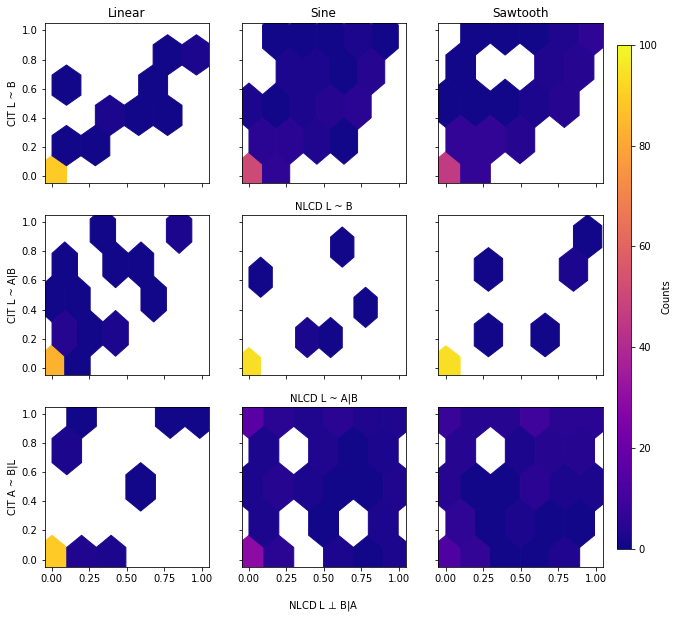

In [87]:
fig3_mod_supp()

In [ ]:
def fig3_supp():

    norows=4
    nocols=3
    nlcd_dir='./results/journal/simulation/nlcd/'
    cit_dir='./results/journal/simulation/cit/'
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Tests comparison of NLCD vs CIT p-values : 500 sample size , 500 permutations ")
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    for plot_index in [0,3,6,9]:
        if plot_index==0:
            x = 'p_LassocB'
            y = 'p_TL'
        elif plot_index==3:
            x='p_LassocA|B'
            y='p_GL'
        elif plot_index==6:
            x='p_AassocB|L'
            y='p_TG'
        elif plot_index==9:
            x='p_LindB|A'
            y='p_Lind'
        for j in ['Linear', 'Sine', 'Saw']: 
                    
            
            curr_ax = ax[plot_index // nocols, plot_index % nocols]
            curr_ax.set_ylabel('')
            curr_ax.set_xlabel('')
            dfnlcd=pd.read_csv(nlcd_dir+j+'KRR500s500perm.csv')
            dfcit=pd.read_csv(cit_dir+j+'500cit500perm.csv') 

            #return dfnlcd[x],dfcit[y]
            hb=curr_ax.hexbin(dfnlcd[x], dfcit[y], gridsize=5,mincnt=1, cmap='Blues',vmin=0,vmax=100)
            #if(j=='Sine' and x=='p_AassocB|L'):
            #    cbar = fig.colorbar(hb, cax=cbar_ax)
            if(plot_index//nocols == 0 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel('<----------NLCD L ~ B---------->')
            if(plot_index//nocols == 1 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel('<----------NLCD L ~ A|B-------->')
            if(plot_index//nocols == 2 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel('<----------NLCD A ~ B|L-------->')
            if(plot_index//nocols == 3 and plot_index % nocols ==1 ):
                curr_ax.set_xlabel(r'<----------NLCD L $\bot$ B|A-------->')

            if(plot_index // nocols == 0 and plot_index % nocols == 0):
                curr_ax.set_title('Linear')
            elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                curr_ax.set_title('Sine')
            elif(plot_index // nocols == 0 and plot_index % nocols == 2):
                curr_ax.set_title('Sawtooth')   
            if(plot_index % nocols == 0 and plot_index//nocols == 0):
                curr_ax.set_ylabel(' CIT L ~ B')
            if(plot_index % nocols == 0 and plot_index//nocols == 1 ):
                curr_ax.set_ylabel(' CIT L ~ A|B')
            if(plot_index % nocols == 0 and plot_index // nocols == 2):
                curr_ax.set_ylabel(' CIT A ~ B|L')
            if(plot_index % nocols == 0 and plot_index // nocols == 3):
                curr_ax.set_ylabel(r' CIT L $\bot$ B|A')
            
            

            plot_index += 1

    cbar = fig.colorbar(hb, cax=cbar_ax)
    #cbar = fig.colorbar
    cbar.set_label('Counts')

    #plt.savefig("./results/journal/plots/fig_3.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig_3.svg', bbox_inches='tight',format='svg', dpi=1200)

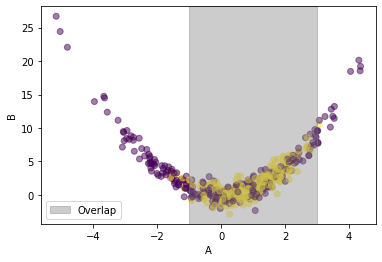

In [63]:
df=read_data('./data/Paravar500.txt')
i=4
A=df[i][1]
B=df[i][2]
L=df[i][0]
plt.scatter(A,B,c=L,alpha=0.5)
#plt.title("Parabola with unequal variance ")
plt.xlabel('A')
plt.ylabel('B')
plt.axvspan(xmin=-1, xmax=3, alpha=0.4, color='gray',label='Overlap') 
plt.legend()

plt.savefig("./results/journal/plots/fig4_example.png",bbox_inches='tight',dpi=1200)
plt.savefig('./results/journal/plots/fig4_example.svg', bbox_inches='tight',format='svg', dpi=1200)

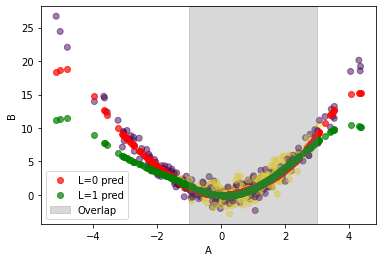

In [64]:
# Parabola 500: i=4 for example 
#plt.title("Plot of L=0 and L=1 predictions of NLCD on the data")
plt.scatter(A,B,c=L,alpha=0.5)
plt.xlabel('A')
plt.ylabel('B')
y_pred_original=compute_Luniqs_predns(L,A,B,'KRR')
plt.scatter(A,y_pred_original[0],label='L=0 pred',alpha=0.7,color='red')
plt.scatter(A,y_pred_original[1],label='L=1 pred',alpha=0.7,color='green')
plt.axvspan(xmin=-1, xmax=3, alpha=0.3, color='gray',label='Overlap') 
plt.legend()
plt.savefig("./results/journal/plots/fig4_example_L.png",bbox_inches='tight',dpi=1200)
plt.savefig('./results/journal/plots/fig4_example_L.svg', bbox_inches='tight',format='svg', dpi=1200)

In [ ]:
plt.title("Plot of L=0 and L=1 predictions of NLCD on the data")
plt.scatter(A,B,c=L,alpha=0.5)
plt.xlabel('A')
plt.ylabel('B')
y_pred_original=compute_Luniqs_predns(L,A,B,'KRR')
plt.scatter(A,y_pred_original[0],label='L=0 pred',alpha=0.7,color='red')
plt.scatter(A,y_pred_original[1],label='L=1 pred',alpha=0.7,color='green')
plt.axvspan(xmin=-1, xmax=3, alpha=0.3, color='gray',label='Overlap') 
plt.legend()

In [91]:
df=read_data('./gtex/muscle/human_muscle_deseq.txt')
dfconf=read_configuration('./gtex/muscle/human_muscle_deseq.txt')
i=3769
A=df[i][1]
B=df[i][2]
L=df[i][0]

In [26]:
dfconf[dfconf[1].str.contains(f'^.*ENSG00000125347', regex=True)]
#checking if 3769 is the right id 

,0,1,2
3758,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000231925.11
3759,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000123609.10
3760,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000178685.13
3761,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000164136.16
3762,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000133321.10
3763,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000136147.17
3764,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000169871.12
3765,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000123992.18
3766,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000164307.12
3767,chr5_132464413_G_T_b38,ENSG00000125347.13,ENSG00000060491.16


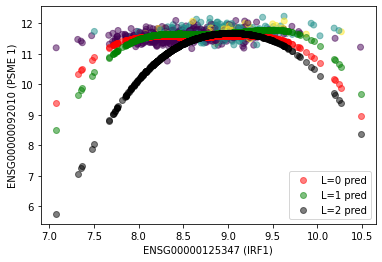

In [93]:
#plt.title("Plot of L=0 and L=1 predictions of NLCD on the data")
plt.scatter(A,B,c=L,alpha=0.5)
plt.xlabel('ENSG00000125347 (IRF1)')
plt.ylabel('ENSG00000092010 (PSME 1)')
y_pred_original=compute_Luniqs_predns(L,A,B,'KRR')
plt.scatter(A,y_pred_original[0],label='L=0 pred',alpha=0.5,color='red')
plt.scatter(A,y_pred_original[1],label='L=1 pred',alpha=0.5,color='green')
plt.scatter(A,y_pred_original[2],label='L=2 pred',alpha=0.5,color='black')
plt.legend()
plt.savefig("./results/journal/plots/human_irf.png",bbox_inches='tight',dpi=1200)
plt.savefig('./results/journal/plots/human_irf.svg', bbox_inches='tight',format='svg', dpi=1200)

In [31]:
def yeastpr():
    ### yeast analysis ################
    #df=read_configuration("../../../findr/findrfiles/scripts/yeastgt_1_wilko1257_ready.txt")
    #possiblecausallist=np.where(~(df[1]==df[2]))[0].tolist()
    #df=read_configuration("../../../findr/findrfiles/scripts/yeastgt_0_wilko1257_ready.txt")
    #possibleindplist=np.where(~(df[1]==df[2]))[0].tolist()
    print("Permutations ", 500)
    precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall("./results/journal/yeast/wilko500/nlcd/yeast_causal.csv", "./results/journal/yeast/wilko500/nlcd/yeast_indp.csv")
    auc_score_nlmr_KRR = auc(recall_nlmr_KRR, precision_nlmr_KRR)
    print("NLCD avg precision ", round(calculate_avgprecision("./results/journal/yeast/wilko500/nlcd/yeast_causal.csv", "./results/journal/yeast/wilko500/nlcd/yeast_indp.csv"),3))
    print("NLCD AUPR ", round(auc_score_nlmr_KRR,3))

    precision_CIT, recall_CIT = calculate_precision_recall("./results/journal/yeast/wilko500/cit/yeast_causal_1234.csv", "./results/journal/yeast/wilko500/cit/yeast_indp_1234.csv")
    auc_score_CIT = auc(recall_CIT, precision_CIT)
    print("CIT avg precision", round(calculate_avgprecision("./results/journal/yeast/wilko500/cit/yeast_causal_1234.csv", "./results/journal/yeast/wilko500/cit/yeast_indp_1234.csv" ),3))
    print("CIT AUPR ", round(auc_score_CIT,3))
    fig, ax = plt.subplots()
    # Plot Precision-Recall curves using PrecisionRecallDisplay
    disp_nlmr_KRR = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
    disp_CIT = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)

    disp_nlmr_KRR.plot(ax=ax,color=color_algo['KRR'], label='NLCD (KRR)')
    disp_CIT.plot(ax=ax,color=color_algo['CIT'], label='CIT (baseline)')

    ax.set_xlabel("Recall")
    ax.set_ylabel('Precision')
    ax.set_title("Yeast Precision-Recall Plot for permutations = 500")
    ax.legend(loc="upper right")
    randomclassifier=1234/(1234+1234)
    ax.axline((0, randomclassifier), (1, randomclassifier), linewidth=1, color='b',linestyle='--')
    plt.tight_layout()

    # Uncomment the lines below if you want to save the plot as an image file
    #plt.savefig("./results/journal/plots/figyeast_pr.png", bbox_inches='tight', dpi=1200)
    #plt.savefig('./results/journal/plots/figyeast_pr.svg', bbox_inches='tight', format='svg', dpi=1200)

    #plt.show()

Permutations  500
NLCD avg precision  0.546
NLCD AUPR  0.546
CIT avg precision 0.563
CIT AUPR  0.564


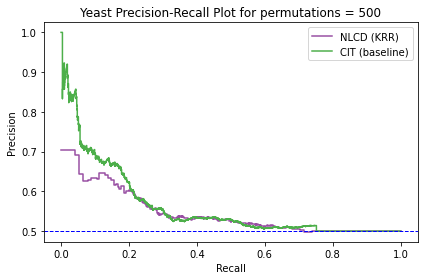

In [32]:
yeastpr()

In [33]:
def yeastbarplot():
    # yeast calculate the avg precision score for all variance for each subset different varaince 
    ### yeast analysis ################
    cutoffs=[0,0.1,0.125,0.15,0.175,0.2,0.225,0.25]
    #df=read_configuration("../../../findr/findrfiles/scripts/yeastgt_1_wilko1257_ready.txt")
    #possiblecausallist=np.where(~(df[1]==df[2]))[0].tolist()
    #df=read_configuration("../../../findr/findrfiles/scripts/yeastgt_0_wilko1257_ready.txt")
    #possibleindplist=np.where(~(df[1]==df[2]))[0].tolist()
    nlcd_mean=[]
    cit_mean=[]
    nlcd_std=[]
    cit_std=[]
    for j in range(len(cutoffs)):
        nlcd_avgprecision=[]
        cit_avgprecision=[]
        nlcd_auc=[]
        cit_auc=[]
        varcausalyeast=pd.read_csv('../../../findr/findrfiles/scripts/var_indices/yeast_wilko_var_causal_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
        varindepyeast=pd.read_csv('../../../findr/findrfiles/scripts/var_indices/yeast_wilko_var_indep_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
        #varcausalyeast=list(set(varcausalyeast).intersection(set(possiblecausallist)))
        #varindepyeast=list(set(varindepyeast).intersection(set(possibleindplist)))
        for i in range(1,11):
            #print("Run ",i)
            avgprecision=calculate_avgprecision("./results/journal/yeast/wilko10runs/nlcd/yeast_causal"+str(i)+".csv", "./results/journal/yeast/wilko10runs/nlcd/yeast_indp"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            nlcd_avgprecision.append(avgprecision)
            #print("NLCD avg precision ", avgprecision)
            avgprecision=calculate_avgprecision("./results/journal/yeast/wilko10runs/cit/yeast_causal_"+str(i)+".csv", "./results/journal/yeast/wilko10runs/cit/yeast_indp_"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            #print("CIT avg precision",avgprecision)
            cit_avgprecision.append(avgprecision)
            precision_CIT, recall_CIT = calculate_precision_recall("./results/journal/yeast/wilko10runs/cit/yeast_causal_"+str(i)+".csv", "./results/journal/yeast/wilko10runs/cit/yeast_indp_"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall("./results/journal/yeast/wilko10runs/nlcd/yeast_causal"+str(i)+".csv", "./results/journal/yeast/wilko10runs/nlcd/yeast_indp"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            auc_score = auc(recall_nlmr_KRR, precision_nlmr_KRR)
            #print("NLCD AUPR ",auc_score)
            nlcd_auc.append(auc_score)
            auc_score = auc(recall_CIT, precision_CIT)
            #print("CIT AUPR ",auc_score)
            cit_auc.append(auc_score)

        nlcd_mean.append(np.mean(nlcd_avgprecision))
        cit_mean.append(np.mean(cit_avgprecision))
        nlcd_std.append(np.std(nlcd_avgprecision))
        cit_std.append(np.std(cit_avgprecision))

    nlcd_mean=np.round(nlcd_mean,3)
    cit_mean=np.round(cit_mean,3)


    species = cutoffs
    algo_means = {
        'CIT': cit_mean,
        'NLCD': nlcd_mean
    }

    x = np.arange(len(species))  # the label locations
    width = 0.4  # the width of the bars, change this if the numbers are overlapping 
    multiplier = 0

    fig, ax = plt.subplots(figsize=(10, 6))

    for attribute, measurement in algo_means.items():
        offset = width * multiplier
        if attribute=='CIT':
            rects = ax.bar(x + offset, measurement, width, yerr=cit_std,label=attribute,color='green',capsize=4)
        else:
            rects = ax.bar(x + offset, measurement, width, yerr=nlcd_std,label=attribute,color='purple',capsize=4)    
        ax.bar_label(rects, padding=5)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Average precision score')
    ax.set_title(r'Average Precision Score across 10 runs with varying Extent of unequal variance ($\Delta\mathrm{var}$)')
    ax.set_xlabel("Extent of unequal variance")
    ax.set_xticks(x + width/2, [0,0.1,0.125,0.15,0.175,0.2,0.225,0.25])
    ax.legend(loc='upper left', ncol=2)
    ax.set_ylim(0.45, 0.65)
    print(np.round(np.mean(nlcd_std),4))
    print(np.round(np.mean(cit_std),4))
    fig.tight_layout()
    #plt.savefig("./results/journal/plots/figyeast_bar.png", bbox_inches='tight', dpi=1200)
    #plt.savefig('./results/journal/plots/figyeast_bar.svg', bbox_inches='tight', format='svg', dpi=1200)


0.0022
0.0006


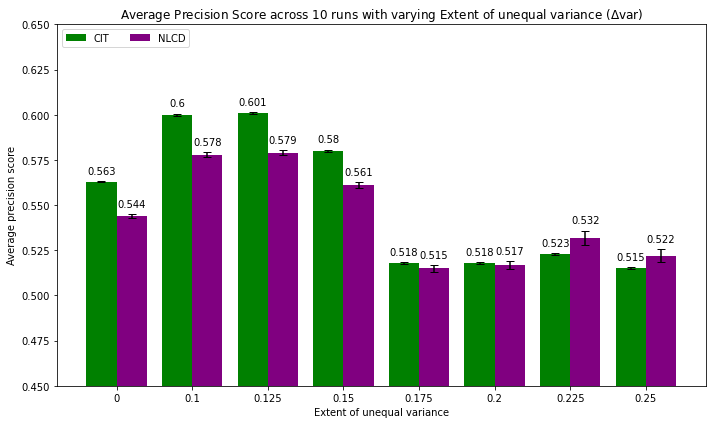

In [34]:
yeastbarplot()

In [42]:
def yeastbarplotauc():
    # yeast calculate the avg precision score for all variance for each subset different varaince 
    ### yeast analysis ################
    cutoffs=[0,0.1,0.125,0.15,0.175,0.2,0.225,0.25]
    #df=read_configuration("../../../findr/findrfiles/scripts/yeastgt_1_wilko1257_ready.txt")
    #possiblecausallist=np.where(~(df[1]==df[2]))[0].tolist()
    #df=read_configuration("../../../findr/findrfiles/scripts/yeastgt_0_wilko1257_ready.txt")
    #possibleindplist=np.where(~(df[1]==df[2]))[0].tolist()
    nlcd_mean=[]
    cit_mean=[]
    nlcd_std=[]
    cit_std=[]
    for j in range(len(cutoffs)):
        nlcd_avgprecision=[]
        cit_avgprecision=[]
        nlcd_auc=[]
        cit_auc=[]
        varcausalyeast=pd.read_csv('../../../findr/findrfiles/scripts/var_indices/yeast_wilko_var_causal_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
        varindepyeast=pd.read_csv('../../../findr/findrfiles/scripts/var_indices/yeast_wilko_var_indep_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
        #varcausalyeast=list(set(varcausalyeast).intersection(set(possiblecausallist)))
        #varindepyeast=list(set(varindepyeast).intersection(set(possibleindplist)))
        for i in range(1,11):
            #print("Run ",i)
            avgprecision=calculate_avgprecision("./results/journal/yeast/wilko10runs/nlcd/yeast_causal"+str(i)+".csv", "./results/journal/yeast/wilko10runs/nlcd/yeast_indp"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            nlcd_avgprecision.append(avgprecision)
            #print("NLCD avg precision ", avgprecision)
            avgprecision=calculate_avgprecision("./results/journal/yeast/wilko10runs/cit/yeast_causal_"+str(i)+".csv", "./results/journal/yeast/wilko10runs/cit/yeast_indp_"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            #print("CIT avg precision",avgprecision)
            cit_avgprecision.append(avgprecision)
            precision_CIT, recall_CIT = calculate_precision_recall("./results/journal/yeast/wilko10runs/cit/yeast_causal_"+str(i)+".csv", "./results/journal/yeast/wilko10runs/cit/yeast_indp_"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall("./results/journal/yeast/wilko10runs/nlcd/yeast_causal"+str(i)+".csv", "./results/journal/yeast/wilko10runs/nlcd/yeast_indp"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
            auc_score = auc(recall_nlmr_KRR, precision_nlmr_KRR)
            #print("NLCD AUPR ",auc_score)
            nlcd_auc.append(auc_score)
            auc_score = auc(recall_CIT, precision_CIT)
            #print("CIT AUPR ",auc_score)
            cit_auc.append(auc_score)


        nlcd_mean.append(np.mean(nlcd_auc))
        cit_mean.append(np.mean(cit_auc))
        nlcd_std.append(np.std(nlcd_auc))
        cit_std.append(np.std(cit_auc))

    nlcd_mean=np.round(nlcd_mean,3)
    cit_mean=np.round(cit_mean,3)


    species = cutoffs
    algo_means = {
        'CIT': cit_mean,
        'NLCD': nlcd_mean
    }

    x = np.arange(len(species))  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(10, 6),layout='constrained')

    for attribute, measurement in algo_means.items():
        offset = width * multiplier
        if attribute=='CIT':
            rects = ax.bar(x + offset, measurement, width, yerr=cit_std,label=attribute,color='green')
        else:
            rects = ax.bar(x + offset, measurement, width, yerr=nlcd_std,label=attribute,color='purple')    
        ax.bar_label(rects, padding=5)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('AUPR score')
    ax.set_xlabel("Extent of unequal variance")
    ax.set_title(r'AUPR across 10 runs with varying Extent of unequal variance ($\Delta\mathrm{var}$)')
    ax.set_xticks(x + width/2, [0,0.1,0.125,0.15,0.175,0.2,0.225,0.25])
    ax.legend(loc='upper left', ncol=2)
    ax.set_ylim(0.45, 0.65)
    print(np.round(np.mean(nlcd_std),4))
    print(np.round(np.mean(cit_std),4))
    #plt.savefig("./results/journal/plots/figyeast_bar_auc.png", bbox_inches='tight', dpi=1200)
    #plt.savefig('./results/journal/plots/figyeast_bar_auc.svg', bbox_inches='tight', format='svg', dpi=1200)

0.0028
0.0008


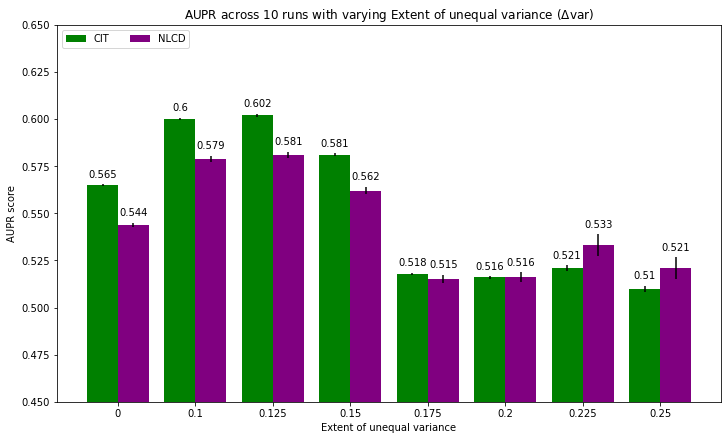

In [43]:
yeastbarplotauc()

In [37]:
'''

def yeastbarplotnlrsubplots():
    # yeast calculate the avg precision score for all variance for each subset different varaince 
    ### yeast analysis ################
    cutoffs = [0, 0.05, 0.1]
    p_values = ['bcmi', 'spear', 'both']
    l_values = [0.05, 0.1, 0.15]

    fig, axs = plt.subplots(len(p_values), len(l_values), figsize=(10, 10),sharex=True,sharey=True)
    fig.suptitle(r'Average Precision Score across 10 runs with varying Extent of nonlinearity ($\Delta\mathrm{var}$) and measures')
    for p_index, p in enumerate(p_values):
        for l_index, l in enumerate(l_values):
            nlcd_mean=[]
            cit_mean=[]
            nlcd_std=[]
            cit_std=[]
            for j in range(len(cutoffs)):
                nlcd_avgprecision=[]
                cit_avgprecision=[]
                nlcd_auc=[]
                cit_auc=[]
                # backup2 has the older files which was a bug 
                #varcausalyeast=pd.read_csv('../../../findr/findrfiles/scripts/backup2/yeast_wilko_mi_causal_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                #varindepyeast=pd.read_csv('../../../findr/findrfiles/scripts/backup2/yeast_wilko_mi_indep_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                varcausalyeast=pd.read_csv('../../../findr/findrfiles/scripts/mpmi_indices/yeast_wilko_mi_causal_'+p+str(l)+'_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                varindepyeast=pd.read_csv('../../../findr/findrfiles/scripts/mpmi_indices/yeast_wilko_mi_indep_'+p+str(l)+'_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                for i in range(1,11):
                    #print("Run ",i)
                    avgprecision=calculate_avgprecision("./results/journal/yeast/wilko10runs/nlcd/yeast_causal"+str(i)+".csv", "./results/journal/yeast/wilko10runs/nlcd/yeast_indp"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    nlcd_avgprecision.append(avgprecision)
                    #print("NLCD avg precision ", avgprecision)
                    avgprecision=calculate_avgprecision("./results/journal/yeast/wilko10runs/cit/yeast_causal_"+str(i)+".csv", "./results/journal/yeast/wilko10runs/cit/yeast_indp_"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    #print("CIT avg precision",avgprecision)
                    cit_avgprecision.append(avgprecision)
                    precision_CIT, recall_CIT = calculate_precision_recall("./results/journal/yeast/wilko10runs/cit/yeast_causal_"+str(i)+".csv", "./results/journal/yeast/wilko10runs/cit/yeast_indp_"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall("./results/journal/yeast/wilko10runs/nlcd/yeast_causal"+str(i)+".csv", "./results/journal/yeast/wilko10runs/nlcd/yeast_indp"+str(i)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    auc_score = auc(recall_nlmr_KRR, precision_nlmr_KRR)
                    #print("NLCD AUPR ",auc_score)
                    nlcd_auc.append(auc_score)
                    auc_score = auc(recall_CIT, precision_CIT)
                    #print("CIT AUPR ",auc_score)
                    cit_auc.append(auc_score)

                nlcd_mean.append(np.mean(nlcd_avgprecision))
                cit_mean.append(np.mean(cit_avgprecision))
                nlcd_std.append(np.std(nlcd_avgprecision))
                cit_std.append(np.std(cit_avgprecision))

            nlcd_mean=np.round(nlcd_mean,3)
            cit_mean=np.round(cit_mean,3)


            species = cutoffs
            algo_means = {
                'CIT': cit_mean,
                'NLCD': nlcd_mean
            }

            x = np.arange(len(species))  # the label locations
            width = 0.4  # the width of the bars , change this if the numbers are overlapping 
            multiplier = 0

            #fig, ax = plt.subplots(figsize=(10, 6),layout='constrained')
            ax=axs[p_index,l_index]

            for attribute, measurement in algo_means.items():
                offset = width * multiplier
                if attribute=='CIT':
                    rects = ax.bar(x + offset, measurement, width, yerr=cit_std,label=attribute,color='green',capsize=4)
                else:
                    rects = ax.bar(x + offset, measurement, width, yerr=nlcd_std,label=attribute,color='purple',capsize=4)    
                ax.bar_label(rects, padding=5)
                multiplier += 1

            # Add some text for labels, title and custom x-axis tick labels, etc.
            #ax.set_ylabel('Average precision score')
            #ax.set_title(r'Average Precision Score across 10 runs with varying Extent of nonlinearity ($\Delta\mathrm{var}$)')
            #ax.set_xlabel("Extent of nonlinearity")
            ax.set_title(f' > {l}')
            #ax.set_ylim(0.3, 0.9)
            ax.set_xticks(x + width/2, [0,0.05,0.1])
            if(p=='bcmi' and l==0.05):
                ax.legend(loc='upper left', ncol=2)
                ax.set_ylabel('Bcmi')
            if(p=='both' and l==0.05):
                ax.set_ylabel('Bcmi and Spearman')
            if(p=='spear' and l==0.05):
                ax.set_ylabel('Average precision score \n spearman')
            if(p=='both' and l==0.1):
                ax.set_xlabel("Extent of nonlinearity")

            ax.set_ylim(0.3, 0.6)
            #print(np.round(np.mean(nlcd_std),4))
            #print(np.round(np.mean(cit_std),4))


            #ax = axs[p_index, l_index]
            #ax.set_title(f'p: {p}, l: {l}')
            #ax.set_ylim(0.3, 0.9)
            #ax.legend(loc='upper left', ncol=2)
    fig.tight_layout()
    #fig.text(0.5, 0.08, "Extent of nonlinearity ODC cutoff", ha='center')
    #fig.text(0.08, 0.5, 'Average Precision Score', va='center', rotation='vertical')
    #plt.savefig("./results/journal/plots/figyeast_bar_nlr.png", bbox_inches='tight', dpi=1200)
    #plt.savefig('./results/journal/plots/figyeast_bar_nlr.svg', bbox_inches='tight', format='svg', dpi=1200)
'''

In [10]:
#yeastbarplotnlrsubplots()

In [40]:
def yeastbarplotnlrsubplots_seedrange(y):
    # yeast calculate the avg precision score for all variance for each subset different varaince 
    ### yeast analysis ################
    cutoffs = [0, 0.05, 0.1]
    p_values = ['bcmi', 'spear', 'both']
    #p_values = [ 'both']
    l_values = [0.05, 0.1, 0.15]
    spearman_causal=pd.read_csv("../../../findr/findrfiles/scripts/mpmi_indices/spearman_cutoff_causal.txt",header=None)[0].to_list()
    #spearman_indep=pd.read_csv("../../../findr/findrfiles/scripts/mpmi_indices/spearman_cutoff_indep.txt",header=None)[0].to_list()
    fig, axs = plt.subplots(len(p_values), len(l_values), figsize=(10, 10),sharex=True,sharey=True)
    fig.suptitle(r'Average Precision Score across 10 seeds for a given run varying ($\Delta\mathrm{var}$)')
    for p_index, p in enumerate(p_values):
        for l_index, l in enumerate(l_values):
            nlcd_mean=[]
            cit_mean=[]
            nlcd_std=[]
            cit_std=[]
            for j in range(len(cutoffs)):
                nlcd_avgprecision=[]
                cit_avgprecision=[]
                nlcd_auc=[]
                cit_auc=[]
                # backup2 has the older files which was a bug 
                #varcausalyeast=pd.read_csv('../../../findr/findrfiles/scripts/backup2/yeast_wilko_mi_causal_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                #varindepyeast=pd.read_csv('../../../findr/findrfiles/scripts/backup2/yeast_wilko_mi_indep_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                for i in range(1,11):
                    varcausalyeast=pd.read_csv('../../../findr/findrfiles/scripts/mpmi_indices/seed'+str(i)+'/yeast_wilko_mi_causal_'+p+str(l)+'_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                    varindepyeast=pd.read_csv('../../../findr/findrfiles/scripts/mpmi_indices/seed'+str(i)+'/yeast_wilko_mi_indep_'+p+str(l)+'_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                
                    #print("Run ",i)
                    avgprecision=calculate_avgprecision("./results/journal/yeast/wilko10runs/nlcd/yeast_causal"+str(y)+".csv", "./results/journal/yeast/wilko10runs/nlcd/yeast_indp"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    nlcd_avgprecision.append(avgprecision)
                    #print("NLCD avg precision ", avgprecision)
                    avgprecision=calculate_avgprecision("./results/journal/yeast/wilko10runs/cit/yeast_causal_"+str(y)+".csv", "./results/journal/yeast/wilko10runs/cit/yeast_indp_"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    #print("CIT avg precision",avgprecision)
                    cit_avgprecision.append(avgprecision)
                    precision_CIT, recall_CIT = calculate_precision_recall("./results/journal/yeast/wilko10runs/cit/yeast_causal_"+str(y)+".csv", "./results/journal/yeast/wilko10runs/cit/yeast_indp_"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall("./results/journal/yeast/wilko10runs/nlcd/yeast_causal"+str(y)+".csv", "./results/journal/yeast/wilko10runs/nlcd/yeast_indp"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    auc_score = auc(recall_nlmr_KRR, precision_nlmr_KRR)
                    #print("NLCD AUPR ",auc_score)
                    nlcd_auc.append(auc_score)
                    auc_score = auc(recall_CIT, precision_CIT)
                    #print("CIT AUPR ",auc_score)
                    cit_auc.append(auc_score)

                nlcd_mean.append(np.mean(nlcd_avgprecision))
                cit_mean.append(np.mean(cit_avgprecision))
                nlcd_std.append(np.std(nlcd_avgprecision))
                cit_std.append(np.std(cit_avgprecision))

            nlcd_mean=np.round(nlcd_mean,3)
            cit_mean=np.round(cit_mean,3)


            species = cutoffs
            algo_means = {
                'CIT': cit_mean,
                'NLCD': nlcd_mean
            }

            x = np.arange(len(species))  # the label locations
            width = 0.4  # the width of the bars , change this if the numbers are overlapping 
            multiplier = 0

            #fig, ax = plt.subplots(figsize=(10, 6),layout='constrained')
            ax=axs[p_index,l_index]
            #ax=axs[l_index]
            for attribute, measurement in algo_means.items():
                offset = width * multiplier
                if attribute=='CIT':
                    rects = ax.bar(x + offset, measurement, width, yerr=cit_std,label=attribute,color='green',capsize=4)
                else:
                    rects = ax.bar(x + offset, measurement, width, yerr=nlcd_std,label=attribute,color='purple',capsize=4)    
                ax.bar_label(rects, padding=5)
                multiplier += 1

            # Add some text for labels, title and custom x-axis tick labels, etc.
            #ax.set_ylabel('Average precision score')
            #ax.set_title(r'Average Precision Score across 10 runs with varying Extent of nonlinearity ($\Delta\mathrm{var}$)')
            #ax.set_xlabel("Extent of nonlinearity")
            if(p=='both'):
                ax.set_title(fr' bcmi > {l} or $\rho$_causal > {np.round(spearman_causal[l_index],3)} ')
            elif(p=='bcmi'):
                ax.set_title(f' bcmi > {l} ')
            elif(p=='spear'):
                ax.set_title(fr' $\rho$_causal > {np.round(spearman_causal[l_index],3)} ')
            #ax.set_ylim(0.3, 0.9)
            ax.set_xticks(x + width/2, [0,0.05,0.1])
            #if(p=='bcmi' and l==0.05):
            #    ax.legend(loc='upper left', ncol=2)
            #    ax.set_ylabel('Bcmi')
            if( l==0.05):
                ax.set_ylabel('AUPR')
            ax.set_ylabel
            #if(p=='spear' and l==0.05):
            #    ax.set_ylabel('Average precision score \n spearman')
            if( l==0.1):
                ax.set_xlabel("Extent of nonlinearity")

            ax.set_ylim(0.3, 1)
            print(np.round(np.mean(nlcd_std),4))
            print(np.round(np.mean(cit_std),4))


            #ax = axs[p_index, l_index]
            #ax.set_title(f'p: {p}, l: {l}')
            #ax.set_ylim(0.3, 0.9)
            #ax.legend(loc='upper left', ncol=2)
    fig.tight_layout()
    #fig.text(0.5, 0.08, "Extent of nonlinearity ODC cutoff", ha='center')
    #fig.text(0.08, 0.5, 'Average Precision Score', va='center', rotation='vertical')
    #plt.savefig("./results/journal/plots/figyeast_bar_nlr_seedyeast_both"+str(y)+".png", bbox_inches='tight', dpi=1200)
    #plt.savefig('./results/journal/plots/figyeast_bar_nlr_seedyeast_both'+str(y)+'.svg', bbox_inches='tight', format='svg', dpi=1200)


In [12]:

#pan.read_csv('list_genes_in_order_01.csv',header=None)[0].to_list()

0.0193
0.0149
0.0166
0.0147
0.0302
0.018
0.0337
0.0176
0.0362
0.0261
0.099
0.0631
0.0194
0.0125
0.0152
0.01
0.0233
0.0119


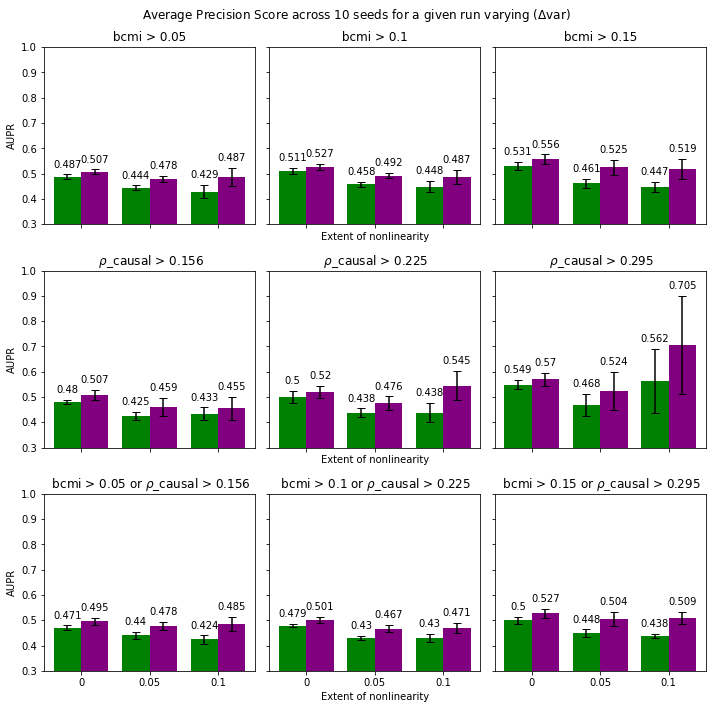

In [41]:
yeastbarplotnlrsubplots_seedrange(1)
 #yeastbarplotnlrsubplots_seedrange(2)
 #yeastbarplotnlrsubplots_seedrange(3)
 #yeastbarplotnlrsubplots_seedrange(4)
 #yeastbarplotnlrsubplots_seedrange(5)
 #yeastbarplotnlrsubplots_seedrange(6)
 #yeastbarplotnlrsubplots_seedrange(7)
 #yeastbarplotnlrsubplots_seedrange(8)
 #yeastbarplotnlrsubplots_seedrange(9)
 #yeastbarplotnlrsubplots_seedrange(10)

In [9]:
'''
This function is not used
def yeastbarplotnlrsubplots_seedrange_others(y):
    # yeast calculate the avg precision score for all variance for each subset different varaince 
    ### yeast analysis ################
    cutoffs = [0, 0.05, 0.1]
    p_values = ['bcmi', 'spear']
    #p_values = [ 'both']
    l_values = [0.05, 0.1, 0.15]
    spearman_causal=pd.read_csv("../../../findr/findrfiles/scripts/mpmi_indices/spearman_cutoff_causal.txt",header=None)[0].to_list()
    spearman_indep=pd.read_csv("../../../findr/findrfiles/scripts/mpmi_indices/spearman_cutoff_indep.txt",header=None)[0].to_list()
    fig, axs = plt.subplots(len(p_values), len(l_values), figsize=(10, 10),sharex=True,sharey=True)
    fig.suptitle(r'Average Precision Score across 10 seeds for a given run varying ($\Delta\mathrm{var}$)')
    for p_index, p in enumerate(p_values):
        for l_index, l in enumerate(l_values):
            nlcd_mean=[]
            cit_mean=[]
            nlcd_std=[]
            cit_std=[]
            for j in range(len(cutoffs)):
                nlcd_avgprecision=[]
                cit_avgprecision=[]
                nlcd_auc=[]
                cit_auc=[]
                # backup2 has the older files which was a bug 
                #varcausalyeast=pd.read_csv('../../../findr/findrfiles/scripts/backup2/yeast_wilko_mi_causal_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                #varindepyeast=pd.read_csv('../../../findr/findrfiles/scripts/backup2/yeast_wilko_mi_indep_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                for i in range(1,11):
                    varcausalyeast=pd.read_csv('../../../findr/findrfiles/scripts/mpmi_indices/seed'+str(i)+'/yeast_wilko_mi_causal_'+p+str(l)+'_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                    varindepyeast=pd.read_csv('../../../findr/findrfiles/scripts/mpmi_indices/seed'+str(i)+'/yeast_wilko_mi_indep_'+p+str(l)+'_'+str(cutoffs[j])+'.csv',header=None)[0].to_list()
                
                    #print("Run ",i)
                    avgprecision=calculate_avgprecision("./results/journal/yeast/wilko10runs/nlcd/yeast_causal"+str(y)+".csv", "./results/journal/yeast/wilko10runs/nlcd/yeast_indp"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    nlcd_avgprecision.append(avgprecision)
                    #print("NLCD avg precision ", avgprecision)
                    avgprecision=calculate_avgprecision("./results/journal/yeast/wilko10runs/cit/yeast_causal_"+str(y)+".csv", "./results/journal/yeast/wilko10runs/cit/yeast_indp_"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    #print("CIT avg precision",avgprecision)
                    cit_avgprecision.append(avgprecision)
                    precision_CIT, recall_CIT = calculate_precision_recall("./results/journal/yeast/wilko10runs/cit/yeast_causal_"+str(y)+".csv", "./results/journal/yeast/wilko10runs/cit/yeast_indp_"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall("./results/journal/yeast/wilko10runs/nlcd/yeast_causal"+str(y)+".csv", "./results/journal/yeast/wilko10runs/nlcd/yeast_indp"+str(y)+".csv",causal_id=varcausalyeast,indep_id=varindepyeast)
                    auc_score = auc(recall_nlmr_KRR, precision_nlmr_KRR)
                    #print("NLCD AUPR ",auc_score)
                    nlcd_auc.append(auc_score)
                    auc_score = auc(recall_CIT, precision_CIT)
                    #print("CIT AUPR ",auc_score)
                    cit_auc.append(auc_score)

                nlcd_mean.append(np.mean(nlcd_avgprecision))
                cit_mean.append(np.mean(cit_avgprecision))
                nlcd_std.append(np.std(nlcd_avgprecision))
                cit_std.append(np.std(cit_avgprecision))

            nlcd_mean=np.round(nlcd_mean,3)
            cit_mean=np.round(cit_mean,3)


            species = cutoffs
            algo_means = {
                'CIT': cit_mean,
                'NLCD': nlcd_mean
            }

            x = np.arange(len(species))  # the label locations
            width = 0.4  # the width of the bars , change this if the numbers are overlapping 
            multiplier = 0

            #fig, ax = plt.subplots(figsize=(10, 6),layout='constrained')
            ax=axs[p_index,l_index]
            #ax=axs[l_index]
            for attribute, measurement in algo_means.items():
                offset = width * multiplier
                if attribute=='CIT':
                    rects = ax.bar(x + offset, measurement, width, yerr=cit_std,label=attribute,color='green',capsize=4)
                else:
                    rects = ax.bar(x + offset, measurement, width, yerr=nlcd_std,label=attribute,color='purple',capsize=4)    
                ax.bar_label(rects, padding=5)
                multiplier += 1

            # Add some text for labels, title and custom x-axis tick labels, etc.
            #ax.set_ylabel('Average precision score')
            #ax.set_title(r'Average Precision Score across 10 runs with varying Extent of nonlinearity ($\Delta\mathrm{var}$)')
            #ax.set_xlabel("Extent of nonlinearity")
            if p=='bcmi':
                ax.set_title(f' bcmi > {l} ')
            else:
                ax.set_title(f' spearman > {l} ')
            #ax.set_ylim(0.3, 0.9)
            ax.set_xticks(x + width/2, [0,0.05,0.1])
            #if(p=='bcmi' and l==0.05):
            #    ax.legend(loc='upper left', ncol=2)
            #    ax.set_ylabel('Bcmi')
            if(l==0.05):
                ax.set_ylabel('AUPR')
            ax.set_ylabel
            #if(p=='spear' and l==0.05):
            #    ax.set_ylabel('Average precision score \n spearman')
            if( l==0.1):
                ax.set_xlabel("Extent of nonlinearity")

            ax.set_ylim(0.3, 0.6)
            print(np.round(np.mean(nlcd_std),4))
            print(np.round(np.mean(cit_std),4))


            #ax = axs[p_index, l_index]
            #ax.set_title(f'p: {p}, l: {l}')
            #ax.set_ylim(0.3, 0.9)
            #ax.legend(loc='upper left', ncol=2)
    fig.tight_layout()
    #fig.text(0.5, 0.08, "Extent of nonlinearity ODC cutoff", ha='center')
    #fig.text(0.08, 0.5, 'Average Precision Score', va='center', rotation='vertical')
    plt.savefig("./results/journal/plots/figyeast_bar_nlr_seedyeast_others"+str(y)+".png", bbox_inches='tight', dpi=1200)
    plt.savefig('./results/journal/plots/figyeast_bar_nlr_seedyeast_others'+str(y)+'.svg', bbox_inches='tight', format='svg', dpi=1200)
    '''


'\nThis function is not used\ndef yeastbarplotnlrsubplots_seedrange_others(y):\n    # yeast calculate the avg precision score for all variance for each subset different varaince \n    ### yeast analysis ################\n    cutoffs = [0, 0.05, 0.1]\n    p_values = [\'bcmi\', \'spear\']\n    #p_values = [ \'both\']\n    l_values = [0.05, 0.1, 0.15]\n    spearman_causal=pd.read_csv("../../../findr/findrfiles/scripts/mpmi_indices/spearman_cutoff_causal.txt",header=None)[0].to_list()\n    spearman_indep=pd.read_csv("../../../findr/findrfiles/scripts/mpmi_indices/spearman_cutoff_indep.txt",header=None)[0].to_list()\n    fig, axs = plt.subplots(len(p_values), len(l_values), figsize=(10, 10),sharex=True,sharey=True)\n    fig.suptitle(r\'Average Precision Score across 10 seeds for a given run varying ($\\Delta\\mathrm{var}$)\')\n    for p_index, p in enumerate(p_values):\n        for l_index, l in enumerate(l_values):\n            nlcd_mean=[]\n            cit_mean=[]\n            nlcd_std=[]

In [11]:
#yeastbarplotnlrsubplots_seedrange_others(1)

In [23]:
def yeasttable():
    cutoff=[]
    ctrios=[]
    cuniquecisL=[]
    cuniquecis=[]
    ctarget=[]
    ceqtl=[]
    itrios=[]
    iuniquecisL=[]
    iuniquecis=[]
    itarget=[]
    ieqtl=[]
    cutoff=  [0,0.1,0.125,0.15,0.175,0.2,0.225,0.25]
    for i in [0,0.1,0.125,0.15,0.175,0.2,0.225,0.25]:
        dfcausal=read_configuration("../../../findr/findrfiles/scripts/yeastgt_1_wilko1234_ready.txt")
        dfindep=read_configuration("../../../findr/findrfiles/scripts/yeastgt_0_wilko1234_ready.txt")
        varcausalyeast=pd.read_csv('../../../findr/findrfiles/scripts/var_indices/yeast_wilko_var_causal_'+str(i)+'.csv',header=None)[0].to_list()
        varindepyeast=pd.read_csv('../../../findr/findrfiles/scripts/var_indices/yeast_wilko_var_indep_'+str(i)+'.csv',header=None)[0].to_list()

        temp=dfcausal.iloc[varcausalyeast,]
        #print("uniq causal",len(temp.drop_duplicates(keep='first')))
        
        ctrios.append(len(temp))
        cuniquecisL.append(len(temp.groupby([0,1]).size()))
        cuniquecis.append(len(pd.unique(temp[1])))
        ctarget.append(len(pd.unique(temp[2])))
        ceqtl.append(len(pd.unique(temp[0])))

        temp=dfindep.iloc[varindepyeast,]
        #print("uniq indp",len(temp.drop_duplicates(keep='first')))

        itrios.append(len(temp))
        iuniquecisL.append(len(temp.groupby([0,1]).size()))
        iuniquecis.append(len(pd.unique(temp[1])))
        itarget.append(len(pd.unique(temp[2])))
        ieqtl.append(len(pd.unique(temp[0])))

    #causaltable=pd.DataFrame({'cutoff':cutoff,'No of causal trios':ctrios,'Unique cis genes wrt L':cuniquecisL,'Unique cis genes':cuniquecis,"Unique target genes":ctarget,"Unique eQTL":ceqtl})
    #indeptable=pd.DataFrame({'cutoff':cutoff,'No of indep trios':itrios,'Unique cis genes wrt L':iuniquecisL,'Unique cis genes':iuniquecis,"Unique target genes":itarget,"Unique eQTL":ieqtl})
    causaltable=pd.DataFrame({'Extent relative difference':cutoff,'No of causal trios':ctrios,'Unique cis genes':cuniquecis,"Unique target genes":ctarget})
    indeptable=pd.DataFrame({'Extent relative difference':cutoff,'No of indep trios':itrios,'Unique cis genes':iuniquecis,"Unique target genes":itarget})
    
    return causaltable,indeptable
        

In [24]:
causaltable,indeptable= yeasttable()

In [30]:
indeptable

,Extent relative difference,No of indep trios,Unique cis genes,Unique target genes
0,0.000,1234,58,1019
1,0.100,683,32,622
2,0.125,673,28,612
3,0.150,553,21,513
4,0.175,353,16,334
5,0.200,239,14,231
6,0.225,120,13,117
7,0.250,113,11,111


In [131]:
causaltable.to_csv("causaltableyeast.csv",header=True)
indeptable.to_csv("indeptableyeast.csv",header=True)

In [35]:
#scatter plot of KLF5 ENSG00000102554  and SLC17A9 ENSG00000101194
df=read_data('./gtex/adipose/human_adipose_deseq.txt')
dfconf=read_configuration('./gtex/adipose/human_adipose_deseq.txt')

In [38]:
# get the row number of SDHAP2 : ENSG00000215837.7, AC024560.2 : ENSG00000236833.1
dfconf[dfconf[1]=="ENSG00000215837.7"]

,0,1,2
4227,chr3_195934570_C_A_b38,ENSG00000215837.7,ENSG00000236833.1
4228,chr3_195934570_C_A_b38,ENSG00000215837.7,ENSG00000261757.1


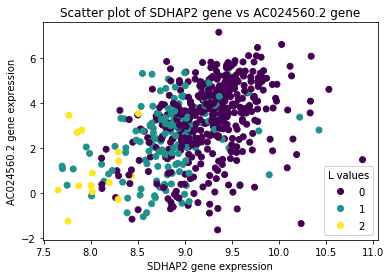

In [42]:

fig, ax = plt.subplots()

scatter = ax.scatter(df[4227][1], df[4227][2], c=df[4227][0])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="L values")
ax.add_artist(legend1)
ax.set_title("Scatter plot of SDHAP2 gene vs AC024560.2 gene")
ax.set_xlabel("SDHAP2 gene expression")
ax.set_ylabel("AC024560.2 gene expression")
plt.savefig("./results/journal/plots/fig_muscle_scatter.png", bbox_inches='tight', dpi=1200)
plt.savefig('./results/journal/plots/fig_muscle_scatter.svg', bbox_inches='tight', format='svg', dpi=1200)


In [7]:
def find_aupr():
    ### Figure 2 supplementary ################
    nlcd_dir="./results/journal/simulation/nlcd/"
    cit_dir="./results/journal/simulation/cit/"
    norows=3
    nocols=3
    fig, ax = plt.subplots(nrows=norows, ncols=nocols, sharex=True, sharey=True, figsize=(10,10))
    fig.suptitle("Precision-Recall Curve plots for 500 permutations ")
    #fig.text(0.5, 1, 'Precision-Recall Curve plots', ha='center')
    #fig.text(0.22, 1, 'Linear', ha='center')
    #fig.text(0.52, 1, 'Sine', ha='center')
    #fig.text(0.85, 1, 'Saw', ha='center')
    #fig.text(0,0.20, 'Sample size 1000', va='center', rotation='vertical')
    #fig.text(0,0.50, 'Sample size 500', va='center', rotation='vertical')
    #fig.text(0,0.79, 'Sample size 300', va='center', rotation='vertical')

    plot_index = 0
    avg_auc_nlmr_sine=0
    avg_auc_cit_sine=0
    avg_auc_nlmr_saw=0
    avg_auc_cit_saw=0
    count=0
    for i in ['300', '500', '1000'] :
     
        for j in ['Linear', 'Sine', 'Saw']:
            for k in [ '500']: # put 100 permutations in supplementary 
                precision_nlmr_SVR, recall_nlmr_SVR = calculate_precision_recall(nlcd_dir + j + "SVR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpSVR" + i + "s" + k + "perm.csv")
                
                precision_nlmr_KRR, recall_nlmr_KRR = calculate_precision_recall(nlcd_dir + j + "KRR" + i + "s" + k + "perm.csv", nlcd_dir+"IndpKRR" + i + "s" + k + "perm.csv")
                print("NLMR (KRR) Sample size", i, "Data type", j, "AUPR", auc(recall_nlmr_KRR, precision_nlmr_KRR))
                if(j=='Saw'):
                    avg_auc_nlmr_saw+=auc(recall_nlmr_KRR,precision_nlmr_KRR)
                if(j=='Sine'):
                    avg_auc_nlmr_sine+=auc(recall_nlmr_KRR, precision_nlmr_KRR)
                precision_nlmr_ANN, recall_nlmr_ANN = calculate_precision_recall(nlcd_dir + j + "ANN" + i + "s" + k + "perm.csv", nlcd_dir+"IndpANN" + i + "s" + k + "perm.csv")
                precision_CIT, recall_CIT = calculate_precision_recall(cit_dir + j + i + "cit" + k + "perm.csv", cit_dir+"Indp" + i + "cit" + k + "perm.csv")
                print("CIT Sample size", i, "Data type", j, "AUPR", auc(recall_CIT, precision_CIT))
                if(j=='Saw'):
                    avg_auc_cit_saw+=auc(recall_CIT,precision_CIT)
                if(j=='Sine'):
                    print(avg_auc_cit_sine)
                    avg_auc_cit_sine+=auc(recall_CIT, precision_CIT)
                    count+=1
                curr_ax = ax[plot_index // nocols, plot_index % nocols]
                
                #curr_ax.plot(recall_CIT,precision_CIT,color=color_algo['CIT'])
                #curr_ax.plot(recall_nlmr_ANN,precision_nlmr_ANN,color=color_algo['ANN'])
                #curr_ax.plot(recall_nlmr_SVR,precision_nlmr_SVR,color=color_algo['SVR'])
                #curr_ax.plot(recall_nlmr_KRR,precision_nlmr_KRR,color=color_algo['KRR'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_SVR, recall=recall_nlmr_SVR)
                disp.plot(ax=curr_ax, color=color_algo['SVR'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_ANN, recall=recall_nlmr_ANN)
                disp.plot(ax=curr_ax, color=color_algo['ANN'])
                disp = PrecisionRecallDisplay(precision=precision_CIT, recall=recall_CIT)
                disp.plot(ax=curr_ax, color=color_algo['CIT'])
                disp = PrecisionRecallDisplay(precision=precision_nlmr_KRR, recall=recall_nlmr_KRR)
                disp.plot(ax=curr_ax, color=color_algo['KRR'])
                curr_ax.set_ylabel('')
                curr_ax.set_xlabel('')
                if(plot_index // nocols == 0 and plot_index % nocols == 0):
                    curr_ax.set_title('Linear')
                elif(plot_index // nocols == 0 and plot_index % nocols == 1):
                    curr_ax.set_title('Sine')
                elif(plot_index // nocols == 0 and plot_index % nocols == 2):
                    curr_ax.set_title('Sawtooth')   
                if(plot_index % nocols == 0 and plot_index//norows==0):
                    curr_ax.set_ylabel('Sample size =300 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==1):
                    curr_ax.set_ylabel('Sample size =500 \n Precision')
                if(plot_index % nocols == 0 and plot_index//norows==2):
                    curr_ax.set_ylabel('Sample size =1000 \n Precision')
                if(plot_index //nocols == (norows-1)):
                    curr_ax.set_xlabel('Recall')
                if(plot_index // nocols == norows-1 and plot_index % nocols == 0) :# if the plot is lower left, then add the legend in that plot
                    xindex=norows-1
                    yindex=0
                    handles = [ax[xindex, yindex].lines[3],ax[xindex,yindex].lines[0], ax[xindex, yindex].lines[1],ax[xindex, yindex].lines[2]]
                    labels = ['NLCD (KRR)','NLCD (SVR)', 'NLCD (ANN)',  'CIT (baseline)']
                    curr_ax.legend(handles,labels,loc="lower left")
            
                
                plot_index += 1
        #print(avg_auc_cit)
        #print(avg_auc_nlmr)
        #print(count)
    avg_auc_cit_sine/=3
    avg_auc_nlmr_sine/=3
    avg_auc_cit_saw/=3
    avg_auc_nlmr_saw/=3
    print("Sine Average auc CIT",avg_auc_cit_sine)
    print("Sine Average auc NLMR",avg_auc_nlmr_sine)
    print("Saw Average auc CIT",avg_auc_cit_saw)
    print("Saw Average auc NLMR",avg_auc_nlmr_saw)
    print("Average of CIT",(avg_auc_cit_sine+avg_auc_cit_saw)/2)
    print("Average of NLCD",(avg_auc_nlmr_sine+avg_auc_nlmr_saw)/2)
    fig.tight_layout()
    #plt.savefig("./results/journal/plots/fig_2_suppl_a.png",bbox_inches='tight',dpi=1200)
    #plt.savefig('./results/journal/plots/fig_2_suppl_a.svg', bbox_inches='tight',format='svg', dpi=1200)

NLMR (KRR) Sample size 300 Data type Linear AUPR 0.9442228715906973
CIT Sample size 300 Data type Linear AUPR 0.9169407437994103
NLMR (KRR) Sample size 300 Data type Sine AUPR 0.7674378731361557
CIT Sample size 300 Data type Sine AUPR 0.6153730031748965
0
NLMR (KRR) Sample size 300 Data type Saw AUPR 0.678020777758964
CIT Sample size 300 Data type Saw AUPR 0.5147555095171252
NLMR (KRR) Sample size 500 Data type Linear AUPR 0.9451755982298657
CIT Sample size 500 Data type Linear AUPR 0.9475981142150545
NLMR (KRR) Sample size 500 Data type Sine AUPR 0.7995303676047848
CIT Sample size 500 Data type Sine AUPR 0.6438583788252574
0.6153730031748965
NLMR (KRR) Sample size 500 Data type Saw AUPR 0.7317370770544727
CIT Sample size 500 Data type Saw AUPR 0.5755032690116539
NLMR (KRR) Sample size 1000 Data type Linear AUPR 0.9442076751885035
CIT Sample size 1000 Data type Linear AUPR 0.9551997348010387
NLMR (KRR) Sample size 1000 Data type Sine AUPR 0.787983696334795
CIT Sample size 1000 Data typ

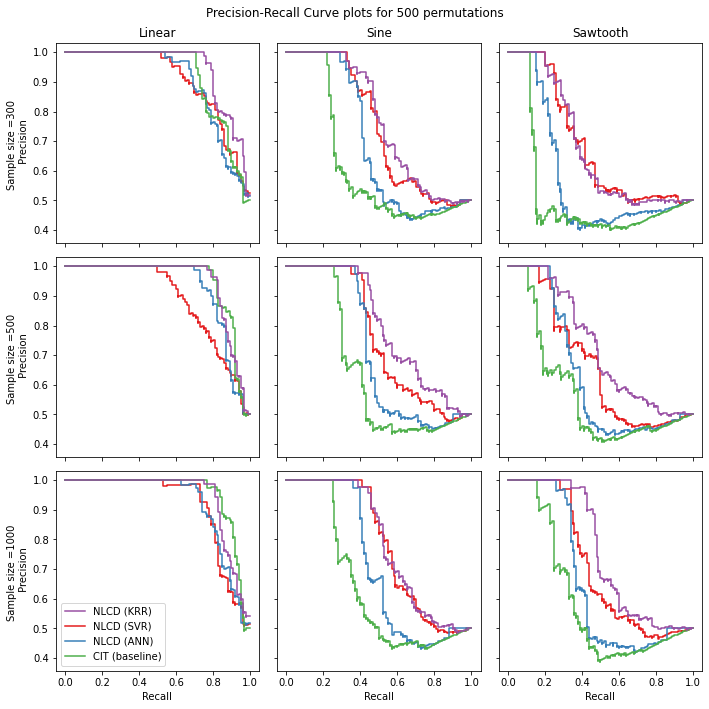

In [8]:
find_aupr()